In [1]:
import numpy as np
import torch
import torch.optim as optim
import os
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# Defining Functions

## REINFORCE

In [3]:
# Stoichiometric matrix defining the effect of each reaction on the system
stoic_matrix = torch.tensor([[2.0, 0.0],    # Reaction 1: Promoter state goes from -1 to +1
                             [0.0, 1.0],    # Reaction 2: mRNA is produced
                             [-2.0, 0.0],   # Reaction 3: Promoter state goes from +1 to -1
                             [0.0, -1.0]])  # Reaction 4: Degradation of mRNA

def propensities(levels, poff, r, g):
    promoter, mRNA = levels
    k_on = (1.0 - poff) / poff

    # Use `.float()` and ensure all terms are 0-dim tensors
    a1 = (k_on * (promoter == -1).float()).reshape(())
    a2 = (r * (promoter == -1).float()).reshape(())
    a3 = (1.0 * (promoter == +1).float()).reshape(())
    a4 = (g * mRNA).reshape(())

    return torch.stack([a1, a2, a3, a4])

def run_trajectories(poff, r, g, num_simulations):
    all_trajectories = []
    final_states = []

    random_seed = torch.randint(1, 10000000, (1,))
    torch.manual_seed(random_seed)
    
    for _ in range(num_simulations):
        levels = torch.tensor([-1.0, 0.0], device=device)
        t = 0.0
        trajectory = []

        while t < sim_time:
            a = torch.relu(propensities(levels, poff, r, g))
            a0 = a.sum()

            if not torch.isfinite(a0) or a0.item() <= 1e-8:
                break

            tau = -torch.log(torch.rand(1, device=device)) / a0
            probs = a / a0
            
            if not torch.all(torch.isfinite(probs)) or torch.any(probs < 0):
                print(f"Invalid probabilities encountered, skipping trajectory")
                break

            j = torch.multinomial(probs, 1).item()

            trajectory.append((levels.clone(), j, tau.item()))
            levels = levels + stoic_matrix[j]
            levels[1] = torch.relu(levels[1])
            t += tau.item()

        all_trajectories.append(trajectory)
        final_states.append(levels[1])

    final_states = torch.stack(final_states)
    mean_mRNA = final_states.mean()
    variance = final_states.var(unbiased=False)

    return all_trajectories, mean_mRNA, variance

def run_trajectories(poff, r, g, num_simulations, gen: torch.Generator | None = None):
    all_trajectories = []
    final_states = []
    eps = 1e-8

    for _ in range(num_simulations):
        levels = torch.tensor([-1.0, 0.0], device=device)
        t = 0.0
        trajectory = []

        while t < sim_time:
            a = torch.clamp(propensities(levels, poff, r, g), min=eps)  # clamp instead of relu
            a0 = a.sum()
            if not torch.isfinite(a0) or a0.item() <= eps:
                break

            u = torch.rand(1, device=device, generator=gen)
            tau = -torch.log(u) / a0

            probs = a / a0
            if (not torch.isfinite(probs).all()) or (probs < 0).any():
                break

            j = torch.multinomial(probs, 1, generator=gen).item()

            trajectory.append((levels.clone(), j, float(tau)))
            levels = levels + stoic_matrix[j]
            levels[1] = torch.clamp(levels[1], min=0.0)  # nonnegative species
            t += float(tau)

        all_trajectories.append(trajectory)
        final_states.append(levels[1])

    final_states = torch.stack(final_states)
    mean_mRNA = final_states.mean()
    variance = final_states.var(unbiased=False)
    return all_trajectories, mean_mRNA, variance


def reinforce_estimate(poff, r, g, mean_data, var_data, num_simulations, gen):
    # Sample trajectories once
    all_trajectories, mean_mRNA, variance = run_trajectories(poff, r, g, num_simulations, gen)

    # Reward based on both mean and variance
    loss = (mean_mRNA - mean_data) ** 2 + (torch.sqrt(variance) - torch.sqrt(var_data)) ** 2

    # Pick one trajectory (e.g. the first one) for REINFORCE
    trajectory = all_trajectories[0]

    eps = 1e-8

    log_grad = [torch.tensor(0.0, dtype=torch.float32, device=poff.device) for _ in range(3)]

    poff_, r_, g_ = poff.clone().detach().requires_grad_(), r.clone().detach().requires_grad_(), g.clone().detach().requires_grad_()

    for (x_prev, j, tau) in trajectory:
        #a = torch.relu(propensities(x_prev, poff_, r_, g_))
        a = torch.clamp(propensities(x_prev, poff_, r_, g_), min=1e-8)
        a0 = a.sum()
        aj = a[j]

        d_aj = torch.autograd.grad(aj, (poff_, r_, g_), retain_graph=True, allow_unused=True)
        d_a0 = torch.autograd.grad(a0, (poff_, r_, g_), retain_graph=True, allow_unused=True)

        d_aj = [g if g is not None else torch.tensor(0.0, dtype=torch.float32, device=poff.device) for g in d_aj]
        d_a0 = [g if g is not None else torch.tensor(0.0, dtype=torch.float32, device=poff.device) for g in d_a0]

        aj_safe = aj if aj.abs() > eps else eps
        log_grad_step = [daj_i / aj_safe - tau * da0_i for daj_i, da0_i in zip(d_aj, d_a0)]

        log_grad = [sum(x) for x in zip(log_grad, log_grad_step)] if isinstance(log_grad, list) else log_grad_step

    # Scale log grad by reward (loss)
    reinforce_grad = [grad_i * loss for grad_i in log_grad]

    return reinforce_grad[0], reinforce_grad[1], reinforce_grad[2], loss

# Define a function to write data to a file
def write_to_file(filename, *args):
    with open(filename, 'a') as file:
        file.write(' '.join(map(str, args)) + '\n')

## REINFORCE with Baseline

In [6]:
def reinforce_estimate_baseline(poff, r, g, mean_data, var_data, num_simulations, gen):
    #define epsilon 
    eps = 1e-8
    
    # Sample trajectories once
    all_trajectories, mean_mRNA, variance = run_trajectories(poff, r, g, num_simulations, gen)

    # Reward based on both mean and variance
    loss = (mean_mRNA - mean_data) ** 2 + (torch.sqrt(variance) - torch.sqrt(var_data)) ** 2

    # Pick one trajectory (e.g. the first one) for REINFORCE
    trajectory = all_trajectories[0]

    #estimate the baseline
    eval_seed = 2_000_003  # any number independent of training seed schedule
    eval_gen  = torch.Generator(device=poff.device).manual_seed(eval_seed + 7919)  # +offset if you like
    
    with torch.no_grad():
        baseline_vals = []
        for k in range(10):
            _, m_bl, v_bl = run_trajectories(poff, r, g, 50, eval_gen)
            bl = (m_bl - mean_data)**2 + (torch.sqrt(torch.clamp(v_bl, min=1e-8)) - torch.sqrt(torch.clamp(var_data, min=1e-8)))**2
            baseline_vals.append(bl)
        baseline = torch.mean(torch.stack(baseline_vals))

    advantage = loss - baseline

    log_grad = [0.0, 0.0, 0.0]

    poff_, r_, g_ = poff.clone().detach().requires_grad_(), r.clone().detach().requires_grad_(), g.clone().detach().requires_grad_()

    for (x_prev, j, tau) in trajectory:
        a = torch.clamp(propensities(x_prev, poff_, r_, g_), min=eps)
        a0 = a.sum()
        aj = a[j]

        d_aj = torch.autograd.grad(aj, (poff_, r_, g_), retain_graph=True, allow_unused=True)
        d_a0 = torch.autograd.grad(a0, (poff_, r_, g_), retain_graph=True, allow_unused=True)

        d_aj = [g if g is not None else torch.tensor(0.0, device=poff.device) for g in d_aj]
        d_a0 = [g if g is not None else torch.tensor(0.0, device=poff.device) for g in d_a0]

        aj_safe = aj if aj.abs() > eps else eps
        log_grad_step = [daj_i / aj_safe - tau * da0_i for daj_i, da0_i in zip(d_aj, d_a0)]

        log_grad = [sum(x) for x in zip(log_grad, log_grad_step)] if isinstance(log_grad, list) else log_grad_step

    # Scale log grad by reward (loss) - multiply by advantage instead of raw loss
    reinforce_grad = [grad_i * advantage for grad_i in log_grad]

    return reinforce_grad[0], reinforce_grad[1], reinforce_grad[2], loss

## RLOO

In [9]:
def RLOO_trajectories(poff, r, g, gen):
    
    all_trajectories = []
    final_states = []
    
    for _ in range(num_simulations):
        levels = torch.tensor([-1.0, 0.0], device=device)
        t = 0.0
        trajectory = []

        while t < sim_time:
            a = torch.relu(propensities(levels, poff, r, g))
            a0 = a.sum()

            if a0.item() <= 1e-8 or torch.isnan(a0):
                break

            tau = -torch.log(torch.rand(1, device=device)) / a0
            probs = a / a0
            j = torch.multinomial(probs, 1).item()

            trajectory.append((levels.clone(), j, tau.item()))
            levels = levels + stoic_matrix[j]
            levels[1] = torch.relu(levels[1])
            t += tau.item()

        all_trajectories.append(trajectory)
        final_states.append(levels[1])
        

    final_states = torch.stack(final_states)

    return all_trajectories, final_states


def RLOO_trajectories(poff, r, g, gen):
    all_trajectories, final_states = [], []
    for _ in range(num_simulations):
        levels = torch.tensor([-1.0, 0.0], device=device)
        t, trajectory = 0.0, []
        while t < sim_time:
            a = propensities(levels, poff, r, g)
            a = torch.clamp(a, min=1e-8)
            a0 = a.sum()
            if not torch.isfinite(a0) or a0.item() <= 1e-8:
                break
            u = torch.rand(1, device=device, generator=gen)
            tau = -torch.log(torch.clamp(u, min=1e-12)) / a0
            probs = a / a0
            j = torch.multinomial(probs, 1, generator=gen).item()
            trajectory.append((levels.clone(), j, float(tau)))
            levels = levels + stoic_matrix[j]
            levels[1] = torch.clamp(levels[1], min=0.0)
            t += float(tau)
        all_trajectories.append(trajectory)
        final_states.append(levels[1])
    final_states = torch.stack(final_states)
    return all_trajectories, final_states

def RLOO_estimate(poff, r, g, mean_data, gen):
    all_trajectories, final_states = RLOO_trajectories(poff, r, g, gen)
    N = len(all_trajectories)
    eps = 1e-8

    losses = []
    log_grads = []

    for n in range(N):
        trajectory = all_trajectories[n]
        final_mRNA = final_states[n]

        #per-trajectory loss 
        loss_n = (final_mRNA - mean_data)**2
        losses.append(loss_n)

        # Compute score function gradient ∇ log p(τ_n)
        poff_, r_, g_ = poff.clone().detach().requires_grad_(), r.clone().detach().requires_grad_(), g.clone().detach().requires_grad_()
        log_grad = [0.0, 0.0, 0.0]
        
        for (x_prev, j, tau) in trajectory:
            a = torch.clamp(propensities(x_prev, poff_, r_, g_), min=1e-8)
            a0 = a.sum()
            aj = a[j]
    
            d_aj = torch.autograd.grad(aj, (poff_, r_, g_), retain_graph=True, allow_unused=True)
            d_a0 = torch.autograd.grad(a0, (poff_, r_, g_), retain_graph=True, allow_unused=True)
    
            d_aj = [g if g is not None else torch.tensor(0.0, device=poff.device) for g in d_aj]
            d_a0 = [g if g is not None else torch.tensor(0.0, device=poff.device) for g in d_a0]
    
            aj_safe = aj if aj.abs() > eps else eps
            log_grad_step = [daj_i / aj_safe - tau * da0_i for daj_i, da0_i in zip(d_aj, d_a0)]
    
            log_grad = [sum(x) for x in zip(log_grad, log_grad_step)] if isinstance(log_grad, list) else log_grad_step

        log_grads.append(log_grad)

    #RLOO gradient
    total_loss = torch.sum(torch.stack(losses))
    grad_poff = 0.0
    grad_r = 0.0
    grad_g = 0.0

    for n in range(N):
        baseline = (total_loss - losses[n]) / (N-1)
        advantage = losses[n] - baseline

        #scale the score-function gradient by the RLOO advantage within the loop
        grad_poff += advantage * log_grads[n][0]
        grad_r    += advantage * log_grads[n][1]
        grad_g    += advantage * log_grads[n][2]
    

    # Normalize gradients
    grad_poff /= N
    grad_r    /= N
    grad_g    /= N

    # Also return mean loss for logging
    avg_loss = total_loss / N

    return grad_poff, grad_r, grad_g, avg_loss

# Generate Synthetic Data

to generate synthetic data: 
- randomly sample the 3 parameters k_on, r and gamma within range [0.1,10]
- keep k_off fixed at 1
- generate 20 different setes of random parameters
- perform exact Gillespie simulations for each set of parameters
- obtain mean an dstandard deviation of the mRNA levels using these simulations (used as input to the loss function)
- then use reinforce method to estimate the parameters using the procedure outlined above

note: when using synthetic data, there are degeneracies of the loss function. Degeneracy disappears by also fixing gamma and only optimizing k_on and r 

In [865]:
# Set seeds for reproducibility
random.seed(20)

sample = np.load("random_rates.npy").astype(np.float32)

num_simulations = 50
sim_time = 10.0
num_iterations = 130

# Sample parameters
k_on_syn = sample[:150, 0]
r_syn = sample[:150, 1]
g_syn = sample[:150, 2]
k_off = 1

# Synthetic outputs
syn_mean = []
syn_std = []

# Generate synthetic data for each (k_on, r, g) triple
for i in range(150):
    poff = k_off / (k_on_syn[i] + k_off)
    _, mean_mRNA, variance = run_trajectories(poff, r_syn[i], g_syn[i], num_simulations)  # one-to-one
    syn_mean.append(mean_mRNA)
    syn_std.append(np.sqrt(variance))

sample_array = []
for i in range(150):
    sub_array = np.array([
        k_on_syn[i],       # Row 0: k_on
        r_syn[i],          # Row 1: r
        g_syn[i],          # Row 2: g
        syn_mean[i],       # Row 3: mean
        syn_std[i]         # Row 4: std
    ])
    sample_array.append(sub_array)

# Save to .npy file
np.save("random_rates_mine.npy", sample_array)

# Adam Optimization

In [11]:
#use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## REINFORCE

In [867]:
torch.set_default_dtype(torch.float32)

num_simulations = 50
sim_time = 10.0
num_iterations = 130 #80
R = 3

sample = np.load("random_rates_mine.npy").astype(np.float32)

for num in range(R):

    #filename = f"reinforce_baseline_run{num}.txt"
    filename = f"reinforce_run{num}.txt"
    if os.path.exists(filename):
        os.remove(filename)

    for i in tqdm(range(100)):
        #seeding with generator
        base_seed = 1_000_003*num + 10_007*i
        gen = torch.Generator(device=device).manual_seed(base_seed)
        # init
        poff = torch.nn.Parameter(((1.0 / (1.0 + sample[i, 0])) * (10 ** (-0.7 + 1.4 * torch.rand(1, generator = gen)))).float().to(device))
        while True:
            r = torch.nn.Parameter((sample[i, 1] * (10 ** (-0.7 + 1.4 * torch.rand(1, generator = gen)))).float().to(device))
            g = torch.tensor(sample[i, 2], dtype=torch.float32, device=device)
            if g < r:
                break

        optimizer = optim.Adam([poff, r], lr=0.1)

        target_mean = sample[i, 3]
        target_std  = torch.tensor(sample[i, 4], device=device)

        loss = None
        for iteration in range(num_iterations):
            optimizer.zero_grad()

            dp, dr, _, loss = reinforce_estimate(poff, r, g, target_mean, target_std, num_simulations, gen)

            # assign grads (ensure device matches)
            poff.grad = dp.reshape_as(poff)
            r.grad    = dr.reshape_as(r)

            torch.nn.utils.clip_grad_norm_([poff, r], max_norm=0.2)
            optimizer.step()

            with torch.no_grad():
                poff.clamp_(min=1 / (1 + 100), max=1 / (1 + 0.1))
                r.clamp_(min=0.1, max=100.0)

                st = gen.get_state()
                _, mean_final_state, variance = run_trajectories(poff.detach(), r.detach(), g.detach(), num_simulations, gen)
                gen.set_state(st)

            if loss is not None:
                write_to_file(filename, i, iteration, (1 / poff.item()) - 1.0, r.item(), g.item(),
                    mean_final_state.item(), (variance.sqrt()).item(), (poff * r / g).item(), loss.item())

        print(f"loop {i}, run {num}, loss {loss}")

  1%|▍                                          | 1/100 [00:20<34:36, 20.98s/it]

loop 0, run 0, loss 17.837886810302734


  2%|▊                                          | 2/100 [00:44<36:53, 22.59s/it]

loop 1, run 0, loss 3.898348331451416


  3%|█▏                                       | 3/100 [01:47<1:06:22, 41.06s/it]

loop 2, run 0, loss 3.95235538482666


  4%|█▋                                       | 4/100 [04:15<2:13:15, 83.29s/it]

loop 3, run 0, loss 4.722378253936768


  5%|██                                       | 5/100 [05:43<2:14:34, 84.99s/it]

loop 4, run 0, loss 751.6043090820312


  6%|██▍                                     | 6/100 [08:50<3:07:12, 119.50s/it]

loop 5, run 0, loss 25.311046600341797


  7%|██▊                                      | 7/100 [09:26<2:23:04, 92.30s/it]

loop 6, run 0, loss 64.13861083984375


  8%|███▎                                     | 8/100 [09:45<1:45:29, 68.80s/it]

loop 7, run 0, loss 36.91733169555664


  9%|███▋                                     | 9/100 [12:26<2:28:22, 97.83s/it]

loop 8, run 0, loss 546.9525146484375


 10%|███▉                                   | 10/100 [14:16<2:32:09, 101.44s/it]

loop 9, run 0, loss 22.619083404541016


 11%|████▍                                   | 11/100 [14:32<1:51:44, 75.33s/it]

loop 10, run 0, loss 0.13293561339378357


 12%|████▊                                   | 12/100 [14:50<1:25:06, 58.02s/it]

loop 11, run 0, loss 9.358832359313965


 13%|█████▏                                  | 13/100 [15:13<1:08:26, 47.20s/it]

loop 12, run 0, loss 28.041048049926758


 14%|█████▌                                  | 14/100 [15:45<1:01:05, 42.62s/it]

loop 13, run 0, loss 17.779773712158203


 15%|██████▎                                   | 15/100 [16:06<51:22, 36.27s/it]

loop 14, run 0, loss 4.4899702072143555


 16%|██████▋                                   | 16/100 [16:26<44:00, 31.44s/it]

loop 15, run 0, loss 8.289670944213867


 17%|██████▋                                | 17/100 [24:51<4:00:20, 173.74s/it]

loop 16, run 0, loss 213.076416015625


 18%|███████                                | 18/100 [25:05<2:51:46, 125.69s/it]

loop 17, run 0, loss 15.53537368774414


 19%|███████▌                                | 19/100 [25:17<2:03:42, 91.63s/it]

loop 18, run 0, loss 56.4266357421875


 20%|████████                                | 20/100 [25:30<1:30:31, 67.90s/it]

loop 19, run 0, loss 2.0475783348083496


 21%|████████▍                               | 21/100 [26:27<1:25:03, 64.60s/it]

loop 20, run 0, loss 185.2166748046875


 22%|████████▊                               | 22/100 [27:10<1:15:42, 58.24s/it]

loop 21, run 0, loss 411.85595703125


 23%|█████████▏                              | 23/100 [27:49<1:07:09, 52.33s/it]

loop 22, run 0, loss 1.4968993663787842


 24%|██████████                                | 24/100 [28:23<59:16, 46.80s/it]

loop 23, run 0, loss 10.376531600952148


 25%|██████████▌                               | 25/100 [28:35<45:38, 36.52s/it]

loop 24, run 0, loss 19.50997543334961


 26%|██████████▉                               | 26/100 [29:50<59:09, 47.97s/it]

loop 25, run 0, loss 20.594192504882812


 27%|███████████▎                              | 27/100 [30:34<57:09, 46.98s/it]

loop 26, run 0, loss 6.389193534851074


 28%|███████████▏                            | 28/100 [32:01<1:10:36, 58.84s/it]

loop 27, run 0, loss 555.5220947265625


 29%|███████████▌                            | 29/100 [33:17<1:15:35, 63.88s/it]

loop 28, run 0, loss 5.038989067077637


 30%|████████████                            | 30/100 [33:56<1:05:50, 56.44s/it]

loop 29, run 0, loss 2.3610737323760986


 31%|█████████████                             | 31/100 [34:31<57:33, 50.05s/it]

loop 30, run 0, loss 444.6694641113281


 32%|█████████████▍                            | 32/100 [35:10<52:58, 46.75s/it]

loop 31, run 0, loss 81.52027893066406


 33%|█████████████▊                            | 33/100 [35:29<42:58, 38.48s/it]

loop 32, run 0, loss 2.7513222694396973


 34%|██████████████▎                           | 34/100 [35:55<38:19, 34.84s/it]

loop 33, run 0, loss 1.2970865964889526


 35%|██████████████▋                           | 35/100 [36:24<35:36, 32.87s/it]

loop 34, run 0, loss 134.5749053955078


 36%|███████████████                           | 36/100 [36:54<34:18, 32.16s/it]

loop 35, run 0, loss 0.46348604559898376


 37%|███████████████▌                          | 37/100 [37:11<29:04, 27.69s/it]

loop 36, run 0, loss 0.07338320463895798


 38%|███████████████▉                          | 38/100 [37:27<24:44, 23.94s/it]

loop 37, run 0, loss 5.2956624031066895


 39%|████████████████▍                         | 39/100 [37:54<25:29, 25.08s/it]

loop 38, run 0, loss 1.985619068145752


 40%|████████████████▊                         | 40/100 [38:11<22:33, 22.55s/it]

loop 39, run 0, loss 3.2713217735290527


 41%|█████████████████▏                        | 41/100 [38:39<23:43, 24.13s/it]

loop 40, run 0, loss 137.41513061523438


 42%|█████████████████▋                        | 42/100 [39:22<28:44, 29.73s/it]

loop 41, run 0, loss 6.628368377685547


 43%|██████████████████                        | 43/100 [41:39<59:01, 62.13s/it]

loop 42, run 0, loss 1.088405966758728


 44%|██████████████████▍                       | 44/100 [42:33<55:28, 59.44s/it]

loop 43, run 0, loss 0.9825018644332886


 45%|█████████████████▌                     | 45/100 [46:04<1:36:10, 104.92s/it]

loop 44, run 0, loss 0.15542341768741608


 46%|██████████████████▍                     | 46/100 [46:48<1:18:11, 86.89s/it]

loop 45, run 0, loss 0.058879364281892776


 47%|██████████████████▎                    | 47/100 [54:48<3:00:52, 204.77s/it]

loop 46, run 0, loss 58.090267181396484


 48%|██████████████████▋                    | 48/100 [55:20<2:12:32, 152.94s/it]

loop 47, run 0, loss 87.50315856933594


 49%|███████████████████                    | 49/100 [55:43<1:36:51, 113.95s/it]

loop 48, run 0, loss 14.297762870788574


 50%|████████████████████                    | 50/100 [55:58<1:10:08, 84.18s/it]

loop 49, run 0, loss 16.133460998535156


 51%|█████████████████████▍                    | 51/100 [56:19<53:12, 65.16s/it]

loop 50, run 0, loss 18.32430648803711


 52%|█████████████████████▊                    | 52/100 [56:36<40:34, 50.71s/it]

loop 51, run 0, loss 0.12474815547466278


 53%|██████████████████████▎                   | 53/100 [57:05<34:41, 44.28s/it]

loop 52, run 0, loss 50.468170166015625


 54%|██████████████████████▋                   | 54/100 [58:32<43:52, 57.23s/it]

loop 53, run 0, loss 0.20343166589736938


 55%|███████████████████████                   | 55/100 [59:52<47:58, 63.96s/it]

loop 54, run 0, loss 189.13485717773438


 56%|██████████████████████▍                 | 56/100 [1:00:28<40:46, 55.61s/it]

loop 55, run 0, loss 1.5938656330108643


 57%|█████████████████████                | 57/100 [1:05:42<1:35:19, 133.02s/it]

loop 56, run 0, loss 110.1765365600586


 58%|██████████████████████                | 58/100 [1:06:03<1:09:42, 99.58s/it]

loop 57, run 0, loss 179.2562713623047


 59%|█████████████████████▊               | 59/100 [1:09:27<1:29:28, 130.94s/it]

loop 58, run 0, loss 21.94638442993164


 60%|██████████████████████▊               | 60/100 [1:09:53<1:06:13, 99.34s/it]

loop 59, run 0, loss 1.3111841678619385


 61%|████████████████████████▍               | 61/100 [1:10:03<47:10, 72.57s/it]

loop 60, run 0, loss 0.02216709777712822


 62%|████████████████████████▊               | 62/100 [1:11:43<51:12, 80.86s/it]

loop 61, run 0, loss 56.79825210571289


 63%|███████████████████████▎             | 63/100 [1:14:29<1:05:27, 106.15s/it]

loop 62, run 0, loss 32.982200622558594


 64%|█████████████████████████▌              | 64/100 [1:14:55<49:21, 82.26s/it]

loop 63, run 0, loss 75.82039642333984


 65%|██████████████████████████              | 65/100 [1:17:14<57:54, 99.26s/it]

loop 64, run 0, loss 24.74310302734375


 66%|████████████████████████▍            | 66/100 [1:21:26<1:22:15, 145.16s/it]

loop 65, run 0, loss 201.45108032226562


 67%|████████████████████████▊            | 67/100 [1:23:07<1:12:25, 131.69s/it]

loop 66, run 0, loss 27.484785079956055


 68%|██████████████████████████▌            | 68/100 [1:23:50<56:05, 105.16s/it]

loop 67, run 0, loss 177.5087432861328


 69%|███████████████████████████▌            | 69/100 [1:24:45<46:33, 90.11s/it]

loop 68, run 0, loss 4.527194976806641


 70%|████████████████████████████            | 70/100 [1:24:57<33:25, 66.85s/it]

loop 69, run 0, loss 12.534249305725098


 71%|███████████████████████████▋           | 71/100 [1:27:58<48:50, 101.05s/it]

loop 70, run 0, loss 2992.671630859375


 72%|████████████████████████████▊           | 72/100 [1:28:15<35:23, 75.85s/it]

loop 71, run 0, loss 11.241439819335938


 73%|█████████████████████████████▏          | 73/100 [1:28:33<26:21, 58.57s/it]

loop 72, run 0, loss 6.266379356384277


 74%|█████████████████████████████▌          | 74/100 [1:28:50<19:51, 45.83s/it]

loop 73, run 0, loss 23.2479190826416


 75%|██████████████████████████████          | 75/100 [1:29:36<19:12, 46.10s/it]

loop 74, run 0, loss 20.576642990112305


 76%|██████████████████████████████▍         | 76/100 [1:31:33<26:55, 67.30s/it]

loop 75, run 0, loss 30.324726104736328


 77%|██████████████████████████████▊         | 77/100 [1:31:50<20:02, 52.27s/it]

loop 76, run 0, loss 34.129112243652344


 78%|███████████████████████████████▏        | 78/100 [1:32:10<15:34, 42.49s/it]

loop 77, run 0, loss 1.7102677822113037


 79%|███████████████████████████████▌        | 79/100 [1:32:19<11:22, 32.49s/it]

loop 78, run 0, loss 0.7907292246818542


 80%|████████████████████████████████        | 80/100 [1:32:26<08:18, 24.94s/it]

loop 79, run 0, loss 7.999743461608887


 81%|████████████████████████████████▍       | 81/100 [1:32:38<06:37, 20.92s/it]

loop 80, run 0, loss 0.6943613886833191


 82%|████████████████████████████████▊       | 82/100 [1:33:16<07:46, 25.91s/it]

loop 81, run 0, loss 8.493938446044922


 83%|█████████████████████████████████▏      | 83/100 [1:34:43<12:34, 44.41s/it]

loop 82, run 0, loss 3.682171583175659


 84%|█████████████████████████████████▌      | 84/100 [1:35:12<10:34, 39.68s/it]

loop 83, run 0, loss 4.7070794105529785


 85%|██████████████████████████████████      | 85/100 [1:35:28<08:11, 32.76s/it]

loop 84, run 0, loss 100.44160461425781


 86%|██████████████████████████████████▍     | 86/100 [1:35:40<06:10, 26.49s/it]

loop 85, run 0, loss 1.4170000553131104


 87%|██████████████████████████████████▊     | 87/100 [1:36:57<08:59, 41.51s/it]

loop 86, run 0, loss 2.022442579269409


 88%|███████████████████████████████████▏    | 88/100 [1:39:49<16:07, 80.63s/it]

loop 87, run 0, loss 13.98167610168457


 89%|███████████████████████████████████▌    | 89/100 [1:40:04<11:11, 61.02s/it]

loop 88, run 0, loss 3.7397868633270264


 90%|████████████████████████████████████    | 90/100 [1:40:50<09:24, 56.43s/it]

loop 89, run 0, loss 0.5756919384002686


 91%|████████████████████████████████████▍   | 91/100 [1:41:04<06:34, 43.85s/it]

loop 90, run 0, loss 4.917372226715088


 92%|████████████████████████████████████▊   | 92/100 [1:41:20<04:43, 35.45s/it]

loop 91, run 0, loss 3.6090807914733887


 93%|█████████████████████████████████████▏  | 93/100 [1:41:37<03:29, 29.92s/it]

loop 92, run 0, loss 9.676370620727539


 94%|█████████████████████████████████████▌  | 94/100 [1:41:56<02:40, 26.69s/it]

loop 93, run 0, loss 0.03613463044166565


 95%|██████████████████████████████████████  | 95/100 [1:42:23<02:13, 26.76s/it]

loop 94, run 0, loss 1.8587942123413086


 96%|██████████████████████████████████████▍ | 96/100 [1:42:42<01:37, 24.26s/it]

loop 95, run 0, loss 1.0648903846740723


 97%|██████████████████████████████████████▊ | 97/100 [1:43:55<01:56, 38.92s/it]

loop 96, run 0, loss 5.909327507019043


 98%|███████████████████████████████████████▏| 98/100 [1:44:07<01:02, 31.06s/it]

loop 97, run 0, loss 3.381394147872925


 99%|███████████████████████████████████████▌| 99/100 [1:44:17<00:24, 24.49s/it]

loop 98, run 0, loss 0.021069113165140152


100%|███████████████████████████████████████| 100/100 [1:45:02<00:00, 63.03s/it]


loop 99, run 0, loss 3.2806317806243896


  1%|▍                                          | 1/100 [00:21<36:00, 21.82s/it]

loop 0, run 1, loss 275.3386535644531


  2%|▊                                          | 2/100 [00:43<35:41, 21.85s/it]

loop 1, run 1, loss 0.3285794258117676


  3%|█▎                                         | 3/100 [01:17<44:22, 27.45s/it]

loop 2, run 1, loss 0.008603076450526714


  4%|█▋                                       | 4/100 [02:32<1:14:02, 46.28s/it]

loop 3, run 1, loss 1.6023039817810059


  5%|██                                       | 5/100 [03:23<1:15:38, 47.77s/it]

loop 4, run 1, loss 37.17333221435547


  6%|██▍                                      | 6/100 [04:27<1:23:23, 53.22s/it]

loop 5, run 1, loss 2.4771275520324707


  7%|██▊                                      | 7/100 [07:08<2:17:30, 88.72s/it]

loop 6, run 1, loss 2731.79296875


  8%|███▎                                     | 8/100 [07:30<1:43:28, 67.49s/it]

loop 7, run 1, loss 43.38706970214844


  9%|███▋                                     | 9/100 [08:30<1:38:33, 64.99s/it]

loop 8, run 1, loss 2.368893623352051


 10%|████                                    | 10/100 [08:55<1:19:06, 52.74s/it]

loop 9, run 1, loss 4.922545433044434


 11%|████▍                                   | 11/100 [09:09<1:00:30, 40.79s/it]

loop 10, run 1, loss 0.35718774795532227


 12%|█████                                     | 12/100 [09:35<53:00, 36.14s/it]

loop 11, run 1, loss 181.81741333007812


 13%|█████▍                                    | 13/100 [09:59<47:25, 32.70s/it]

loop 12, run 1, loss 55.64842987060547


 14%|█████▉                                    | 14/100 [10:25<43:38, 30.45s/it]

loop 13, run 1, loss 1.403857707977295


 15%|██████▎                                   | 15/100 [10:37<35:15, 24.89s/it]

loop 14, run 1, loss 0.08910559862852097


 16%|██████▋                                   | 16/100 [11:41<51:29, 36.78s/it]

loop 15, run 1, loss 96.84790802001953


 17%|███████▏                                  | 17/100 [12:18<51:01, 36.89s/it]

loop 16, run 1, loss 61.44554138183594


 18%|███████▌                                  | 18/100 [12:34<42:00, 30.73s/it]

loop 17, run 1, loss 0.5244696736335754


 19%|███████▉                                  | 19/100 [12:57<38:14, 28.33s/it]

loop 18, run 1, loss 102.01406860351562


 20%|████████▍                                 | 20/100 [13:15<33:34, 25.18s/it]

loop 19, run 1, loss 0.5196981430053711


 21%|████████▊                                 | 21/100 [13:52<37:54, 28.79s/it]

loop 20, run 1, loss 53.66433334350586


 22%|████████▊                               | 22/100 [17:24<1:48:44, 83.65s/it]

loop 21, run 1, loss 17541.763671875


 23%|█████████▏                              | 23/100 [18:33<1:41:48, 79.34s/it]

loop 22, run 1, loss 5.090453147888184


 24%|█████████▌                              | 24/100 [20:10<1:47:06, 84.55s/it]

loop 23, run 1, loss 2.8129076957702637


 25%|██████████                              | 25/100 [20:24<1:19:10, 63.34s/it]

loop 24, run 1, loss 0.01080326922237873


 26%|██████████▍                             | 26/100 [21:46<1:25:04, 68.98s/it]

loop 25, run 1, loss 1.88392174243927


 27%|██████████▊                             | 27/100 [22:51<1:22:25, 67.74s/it]

loop 26, run 1, loss 0.9686294794082642


 28%|███████████▏                            | 28/100 [23:19<1:07:05, 55.91s/it]

loop 27, run 1, loss 151.1929931640625


 29%|████████████▏                             | 29/100 [23:54<58:51, 49.74s/it]

loop 28, run 1, loss 0.9613741636276245


 30%|████████████▌                             | 30/100 [24:28<52:29, 44.99s/it]

loop 29, run 1, loss 2.798251152038574


 31%|█████████████                             | 31/100 [24:43<41:22, 35.98s/it]

loop 30, run 1, loss 0.07662062346935272


 32%|█████████████▍                            | 32/100 [25:13<38:48, 34.25s/it]

loop 31, run 1, loss 50.648155212402344


 33%|█████████████▊                            | 33/100 [25:21<29:23, 26.32s/it]

loop 32, run 1, loss 0.27973049879074097


 34%|██████████████▎                           | 34/100 [25:42<27:15, 24.79s/it]

loop 33, run 1, loss 1.9671611785888672


 35%|██████████████▋                           | 35/100 [26:09<27:29, 25.38s/it]

loop 34, run 1, loss 66.32878112792969


 36%|███████████████                           | 36/100 [27:35<46:21, 43.46s/it]

loop 35, run 1, loss 0.772374153137207


 37%|███████████████▌                          | 37/100 [27:56<38:43, 36.89s/it]

loop 36, run 1, loss 26.858642578125


 38%|███████████████▉                          | 38/100 [28:31<37:24, 36.21s/it]

loop 37, run 1, loss 149.482421875


 39%|████████████████▍                         | 39/100 [29:01<34:57, 34.38s/it]

loop 38, run 1, loss 0.13744652271270752


 40%|████████████████▊                         | 40/100 [29:36<34:30, 34.51s/it]

loop 39, run 1, loss 24.121503829956055


 41%|█████████████████▏                        | 41/100 [29:49<27:42, 28.18s/it]

loop 40, run 1, loss 0.2744665741920471


 42%|████████████████▍                      | 42/100 [34:28<1:39:48, 103.26s/it]

loop 41, run 1, loss 178.52536010742188


 43%|████████████████▊                      | 43/100 [36:18<1:40:01, 105.29s/it]

loop 42, run 1, loss 9.215544700622559


 44%|█████████████████▌                      | 44/100 [37:06<1:22:16, 88.14s/it]

loop 43, run 1, loss 0.14772766828536987


 45%|█████████████████▌                     | 45/100 [40:04<1:45:34, 115.17s/it]

loop 44, run 1, loss 0.43980321288108826


 46%|█████████████████▉                     | 46/100 [42:19<1:49:04, 121.19s/it]

loop 45, run 1, loss 0.4670756459236145


 47%|██████████████████▎                    | 47/100 [43:19<1:30:49, 102.81s/it]

loop 46, run 1, loss 0.10386330634355545


 48%|███████████████████▏                    | 48/100 [43:53<1:11:04, 82.01s/it]

loop 47, run 1, loss 76.63948822021484


 49%|████████████████████▌                     | 49/100 [44:03<51:17, 60.35s/it]

loop 48, run 1, loss 3.2997281551361084


 50%|█████████████████████                     | 50/100 [44:17<38:48, 46.57s/it]

loop 49, run 1, loss 15.833770751953125


 51%|█████████████████████▍                    | 51/100 [45:39<46:38, 57.12s/it]

loop 50, run 1, loss 262.4753112792969


 52%|█████████████████████▊                    | 52/100 [46:09<39:17, 49.12s/it]

loop 51, run 1, loss 2.5129075050354004


 53%|██████████████████████▎                   | 53/100 [46:34<32:46, 41.84s/it]

loop 52, run 1, loss 25.006017684936523


 54%|██████████████████████▋                   | 54/100 [47:13<31:21, 40.90s/it]

loop 53, run 1, loss 0.6297953724861145


 55%|███████████████████████                   | 55/100 [49:59<58:55, 78.56s/it]

loop 54, run 1, loss 3155.82177734375


 56%|███████████████████████▌                  | 56/100 [50:10<42:46, 58.32s/it]

loop 55, run 1, loss 22.803911209106445


 57%|███████████████████████▉                  | 57/100 [52:14<55:44, 77.79s/it]

loop 56, run 1, loss 9.194595336914062


 58%|████████████████████████▎                 | 58/100 [52:59<47:39, 68.09s/it]

loop 57, run 1, loss 33.69706726074219


 59%|███████████████████████▌                | 59/100 [55:27<1:02:58, 92.16s/it]

loop 58, run 1, loss 16.04623794555664


 60%|██████████████████████▏              | 60/100 [1:00:09<1:39:20, 149.01s/it]

loop 59, run 1, loss 4.557575702667236


 61%|██████████████████████▌              | 61/100 [1:00:25<1:10:49, 108.97s/it]

loop 60, run 1, loss 1.5104683637619019


 62%|████████████████████████▊               | 62/100 [1:00:45<52:08, 82.33s/it]

loop 61, run 1, loss 3.38024640083313


 63%|█████████████████████████▏              | 63/100 [1:01:20<42:00, 68.13s/it]

loop 62, run 1, loss 17.395849227905273


 64%|█████████████████████████▌              | 64/100 [1:01:49<33:51, 56.43s/it]

loop 63, run 1, loss 178.96701049804688


 65%|██████████████████████████              | 65/100 [1:02:09<26:31, 45.47s/it]

loop 64, run 1, loss 2.920961380004883


 66%|██████████████████████████▍             | 66/100 [1:03:49<35:03, 61.87s/it]

loop 65, run 1, loss 7.745630264282227


 67%|████████████████████████▊            | 67/100 [1:14:22<2:08:18, 233.30s/it]

loop 66, run 1, loss 1154.6363525390625


 68%|█████████████████████████▏           | 68/100 [1:14:42<1:30:16, 169.27s/it]

loop 67, run 1, loss 141.3668670654297


 69%|█████████████████████████▌           | 69/100 [1:15:52<1:12:07, 139.59s/it]

loop 68, run 1, loss 1.8673741817474365


 70%|███████████████████████████▎           | 70/100 [1:16:05<50:43, 101.46s/it]

loop 69, run 1, loss 6.122016429901123


 71%|████████████████████████████▍           | 71/100 [1:16:38<39:10, 81.05s/it]

loop 70, run 1, loss 9.389849662780762


 72%|████████████████████████████▊           | 72/100 [1:17:08<30:41, 65.76s/it]

loop 71, run 1, loss 0.8802857995033264


 73%|█████████████████████████████▏          | 73/100 [1:17:37<24:37, 54.72s/it]

loop 72, run 1, loss 29.745277404785156


 74%|█████████████████████████████▌          | 74/100 [1:17:51<18:23, 42.46s/it]

loop 73, run 1, loss 7.612120151519775


 75%|█████████████████████████████▎         | 75/100 [1:23:01<51:09, 122.78s/it]

loop 74, run 1, loss 21.668701171875


 76%|█████████████████████████████▋         | 76/100 [1:24:00<41:26, 103.62s/it]

loop 75, run 1, loss 15.436189651489258


 77%|██████████████████████████████▊         | 77/100 [1:24:11<29:04, 75.83s/it]

loop 76, run 1, loss 1.156233787536621


 78%|███████████████████████████████▏        | 78/100 [1:24:43<22:58, 62.66s/it]

loop 77, run 1, loss 0.8023302555084229


 79%|███████████████████████████████▌        | 79/100 [1:24:56<16:38, 47.55s/it]

loop 78, run 1, loss 0.2965366840362549


 80%|████████████████████████████████        | 80/100 [1:25:04<11:57, 35.89s/it]

loop 79, run 1, loss 8.96463394165039


 81%|████████████████████████████████▍       | 81/100 [1:25:23<09:42, 30.65s/it]

loop 80, run 1, loss 103.40741729736328


 82%|████████████████████████████████▊       | 82/100 [1:25:39<07:55, 26.40s/it]

loop 81, run 1, loss 1.2740932703018188


 83%|█████████████████████████████████▏      | 83/100 [1:27:27<14:24, 50.88s/it]

loop 82, run 1, loss 5.850154876708984


 84%|████████████████████████████████▊      | 84/100 [1:32:20<32:57, 123.58s/it]

loop 83, run 1, loss 5416.02685546875


 85%|█████████████████████████████████▏     | 85/100 [1:36:19<39:33, 158.24s/it]

loop 84, run 1, loss 1448.6317138671875


 86%|█████████████████████████████████▌     | 86/100 [1:36:37<27:03, 115.98s/it]

loop 85, run 1, loss 8.270113945007324


 87%|█████████████████████████████████▉     | 87/100 [1:39:55<30:27, 140.61s/it]

loop 86, run 1, loss 6.989792823791504


 88%|██████████████████████████████████▎    | 88/100 [1:41:03<23:44, 118.73s/it]

loop 87, run 1, loss 2.755620002746582


 89%|███████████████████████████████████▌    | 89/100 [1:41:13<15:48, 86.26s/it]

loop 88, run 1, loss 1.1807661056518555


 90%|████████████████████████████████████    | 90/100 [1:41:40<11:24, 68.46s/it]

loop 89, run 1, loss 1.8589239120483398


 91%|████████████████████████████████████▍   | 91/100 [1:41:55<07:51, 52.40s/it]

loop 90, run 1, loss 4.575397491455078


 92%|████████████████████████████████████▊   | 92/100 [1:42:14<05:39, 42.41s/it]

loop 91, run 1, loss 13.724903106689453


 93%|█████████████████████████████████████▏  | 93/100 [1:43:10<05:26, 46.58s/it]

loop 92, run 1, loss 1.4097274541854858


 94%|█████████████████████████████████████▌  | 94/100 [1:43:38<04:05, 40.84s/it]

loop 93, run 1, loss 9.56860065460205


 95%|██████████████████████████████████████  | 95/100 [1:44:42<03:58, 47.74s/it]

loop 94, run 1, loss 3.30132794380188


 96%|██████████████████████████████████████▍ | 96/100 [1:45:04<02:39, 39.98s/it]

loop 95, run 1, loss 3.0775206089019775


 97%|██████████████████████████████████████▊ | 97/100 [1:47:17<03:24, 68.06s/it]

loop 96, run 1, loss 729.7484741210938


 98%|███████████████████████████████████████▏| 98/100 [1:47:24<01:39, 49.84s/it]

loop 97, run 1, loss 1.3719303607940674


 99%|███████████████████████████████████████▌| 99/100 [1:47:46<00:41, 41.28s/it]

loop 98, run 1, loss 0.49435779452323914


100%|███████████████████████████████████████| 100/100 [1:49:16<00:00, 65.57s/it]


loop 99, run 1, loss 0.45019251108169556


  1%|▍                                          | 1/100 [00:14<24:37, 14.93s/it]

loop 0, run 2, loss 0.9951401948928833


  2%|▊                                          | 2/100 [00:41<35:07, 21.50s/it]

loop 1, run 2, loss 2.51800274848938


  3%|█▎                                         | 3/100 [01:20<48:01, 29.71s/it]

loop 2, run 2, loss 0.5981694459915161


  4%|█▋                                       | 4/100 [03:00<1:31:54, 57.44s/it]

loop 3, run 2, loss 0.5334672331809998


  5%|██                                       | 5/100 [03:48<1:25:23, 53.94s/it]

loop 4, run 2, loss 7.043529033660889


  6%|██▍                                      | 6/100 [04:43<1:25:10, 54.36s/it]

loop 5, run 2, loss 2.6987862586975098


  7%|██▊                                      | 7/100 [05:11<1:11:04, 45.86s/it]

loop 6, run 2, loss 392.0500793457031


  8%|███▍                                       | 8/100 [05:30<57:18, 37.37s/it]

loop 7, run 2, loss 50.733367919921875


  9%|███▊                                       | 9/100 [06:05<55:21, 36.50s/it]

loop 8, run 2, loss 5.387781143188477


 10%|████                                    | 10/100 [07:19<1:12:17, 48.20s/it]

loop 9, run 2, loss 9.510315895080566


 11%|████▌                                     | 11/100 [07:40<58:55, 39.73s/it]

loop 10, run 2, loss 10.35346794128418


 12%|█████                                     | 12/100 [08:06<52:00, 35.46s/it]

loop 11, run 2, loss 123.77423095703125


 13%|█████▍                                    | 13/100 [08:14<39:42, 27.39s/it]

loop 12, run 2, loss 0.09148819744586945


 14%|█████▉                                    | 14/100 [08:29<33:44, 23.54s/it]

loop 13, run 2, loss 0.32503896951675415


 15%|██████▎                                   | 15/100 [08:43<29:24, 20.76s/it]

loop 14, run 2, loss 1.474223017692566


 16%|██████▋                                   | 16/100 [09:04<29:03, 20.76s/it]

loop 15, run 2, loss 65.53752136230469


 17%|██████▊                                 | 17/100 [12:30<1:45:45, 76.45s/it]

loop 16, run 2, loss 107.39501190185547


 18%|███████▏                                | 18/100 [12:47<1:20:07, 58.63s/it]

loop 17, run 2, loss 9.978949546813965


 19%|███████▌                                | 19/100 [13:07<1:03:21, 46.93s/it]

loop 18, run 2, loss 2.374857187271118


 20%|████████▍                                 | 20/100 [13:30<53:08, 39.86s/it]

loop 19, run 2, loss 12.354024887084961


 21%|████████▊                                 | 21/100 [14:02<49:04, 37.28s/it]

loop 20, run 2, loss 14.75179386138916


 22%|████████▊                               | 22/100 [15:37<1:10:58, 54.59s/it]

loop 21, run 2, loss 94.30055236816406


 23%|█████████▏                              | 23/100 [16:19<1:05:25, 50.98s/it]

loop 22, run 2, loss 1.153372049331665


 24%|██████████                                | 24/100 [16:47<55:50, 44.08s/it]

loop 23, run 2, loss 0.3369363844394684


 25%|██████████▌                               | 25/100 [17:05<45:10, 36.13s/it]

loop 24, run 2, loss 1.660467267036438


 26%|██████████▉                               | 26/100 [17:48<47:19, 38.38s/it]

loop 25, run 2, loss 0.3381699323654175


 27%|██████████▌                            | 27/100 [22:17<2:10:51, 107.55s/it]

loop 26, run 2, loss 2.063544988632202


 28%|██████████▉                            | 28/100 [23:48<2:02:51, 102.38s/it]

loop 27, run 2, loss 5.432966232299805


 29%|███████████▎                           | 29/100 [26:26<2:21:05, 119.23s/it]

loop 28, run 2, loss 0.01809288188815117


 30%|████████████                            | 30/100 [27:06<1:51:10, 95.30s/it]

loop 29, run 2, loss 9.174806594848633


 31%|████████████▍                           | 31/100 [27:23<1:22:37, 71.85s/it]

loop 30, run 2, loss 59.829830169677734


 32%|████████████▊                           | 32/100 [29:46<1:45:43, 93.28s/it]

loop 31, run 2, loss 2148.666259765625


 33%|█████████████▏                          | 33/100 [29:54<1:15:37, 67.72s/it]

loop 32, run 2, loss 1.6896848678588867


 34%|█████████████▎                         | 34/100 [34:30<2:23:15, 130.24s/it]

loop 33, run 2, loss 54.25417709350586


 35%|██████████████                          | 35/100 [34:53<1:46:11, 98.03s/it]

loop 34, run 2, loss 43.153778076171875


 36%|██████████████▍                         | 36/100 [35:31<1:25:22, 80.04s/it]

loop 35, run 2, loss 0.5844212174415588


 37%|██████████████▊                         | 37/100 [35:40<1:01:28, 58.55s/it]

loop 36, run 2, loss 0.0477236770093441


 38%|███████████████▉                          | 38/100 [35:55<47:11, 45.67s/it]

loop 37, run 2, loss 6.597477912902832


 39%|████████████████▍                         | 39/100 [37:10<55:14, 54.34s/it]

loop 38, run 2, loss 47.71828079223633


 40%|████████████████▊                         | 40/100 [38:17<58:04, 58.07s/it]

loop 39, run 2, loss 457.82464599609375


 41%|█████████████████▏                        | 41/100 [38:36<45:41, 46.47s/it]

loop 40, run 2, loss 0.24358536303043365


 42%|█████████████████▋                        | 42/100 [39:05<39:48, 41.17s/it]

loop 41, run 2, loss 14.068395614624023


 43%|██████████████████                        | 43/100 [40:23<49:34, 52.19s/it]

loop 42, run 2, loss 43.287742614746094


 44%|██████████████████▍                       | 44/100 [40:45<40:14, 43.12s/it]

loop 43, run 2, loss 6.663957595825195


 45%|█████████████████▌                     | 45/100 [44:52<1:35:34, 104.27s/it]

loop 44, run 2, loss 14.91934585571289


 46%|█████████████████▉                     | 46/100 [47:00<1:40:27, 111.63s/it]

loop 45, run 2, loss 4.597352981567383


 47%|██████████████████▎                    | 47/100 [48:40<1:35:24, 108.00s/it]

loop 46, run 2, loss 0.700493335723877


 48%|███████████████████▏                    | 48/100 [49:05<1:12:06, 83.20s/it]

loop 47, run 2, loss 32.26211166381836


 49%|████████████████████▌                     | 49/100 [49:28<55:20, 65.11s/it]

loop 48, run 2, loss 11.5787353515625


 50%|█████████████████████                     | 50/100 [49:41<41:15, 49.51s/it]

loop 49, run 2, loss 16.133460998535156


 51%|█████████████████████▍                    | 51/100 [50:01<33:15, 40.73s/it]

loop 50, run 2, loss 50.29267883300781


 52%|█████████████████████▊                    | 52/100 [50:21<27:29, 34.37s/it]

loop 51, run 2, loss 6.929596424102783


 53%|██████████████████████▎                   | 53/100 [50:51<25:56, 33.11s/it]

loop 52, run 2, loss 7.51382303237915


 54%|██████████████████████▋                   | 54/100 [51:37<28:15, 36.85s/it]

loop 53, run 2, loss 0.17674317955970764


 55%|███████████████████████                   | 55/100 [52:05<25:39, 34.20s/it]

loop 54, run 2, loss 335.6240539550781


 56%|███████████████████████▌                  | 56/100 [52:29<22:55, 31.25s/it]

loop 55, run 2, loss 25.70465087890625


 57%|███████████████████████▉                  | 57/100 [53:17<26:01, 36.31s/it]

loop 56, run 2, loss 1.2617343664169312


 58%|████████████████████████▎                 | 58/100 [53:47<24:08, 34.48s/it]

loop 57, run 2, loss 24.55324935913086


 59%|████████████████████████▊                 | 59/100 [55:10<33:22, 48.84s/it]

loop 58, run 2, loss 1.4613007307052612


 60%|██████████████████████▏              | 60/100 [1:00:46<1:29:57, 134.95s/it]

loop 59, run 2, loss 9.202933311462402


 61%|███████████████████████▏              | 61/100 [1:00:54<1:03:04, 97.04s/it]

loop 60, run 2, loss 0.500053346157074


 62%|████████████████████████▊               | 62/100 [1:01:21<48:11, 76.09s/it]

loop 61, run 2, loss 0.17117244005203247


 63%|███████████████████████▎             | 63/100 [1:05:01<1:13:29, 119.18s/it]

loop 62, run 2, loss 349.8619079589844


 64%|█████████████████████████▌              | 64/100 [1:05:25<54:23, 90.66s/it]

loop 63, run 2, loss 180.43057250976562


 65%|██████████████████████████              | 65/100 [1:06:25<47:29, 81.42s/it]

loop 64, run 2, loss 0.15441900491714478


 66%|██████████████████████████▍             | 66/100 [1:07:13<40:22, 71.24s/it]

loop 65, run 2, loss 0.15530523657798767


 67%|██████████████████████████▊             | 67/100 [1:09:45<52:37, 95.68s/it]

loop 66, run 2, loss 39.95799255371094


 68%|█████████████████████████▏           | 68/100 [1:12:35<1:02:48, 117.77s/it]

loop 67, run 2, loss 107.71390533447266


 69%|███████████████████████████▌            | 69/100 [1:13:04<47:06, 91.19s/it]

loop 68, run 2, loss 0.3760668635368347


 70%|████████████████████████████            | 70/100 [1:13:21<34:33, 69.11s/it]

loop 69, run 2, loss 10.14102554321289


 71%|██████████████████████████▎          | 71/100 [1:18:43<1:10:00, 144.85s/it]

loop 70, run 2, loss 1133.3685302734375


 72%|████████████████████████████           | 72/100 [1:19:13<51:32, 110.43s/it]

loop 71, run 2, loss 18.11897087097168


 73%|█████████████████████████████▏          | 73/100 [1:19:25<36:19, 80.74s/it]

loop 72, run 2, loss 0.0597851425409317


 74%|█████████████████████████████▌          | 74/100 [1:19:35<25:47, 59.53s/it]

loop 73, run 2, loss 28.02712631225586


 75%|██████████████████████████████          | 75/100 [1:21:52<34:33, 82.92s/it]

loop 74, run 2, loss 95.66803741455078


 76%|█████████████████████████████▋         | 76/100 [1:26:00<52:57, 132.38s/it]

loop 75, run 2, loss 142.98707580566406


 77%|██████████████████████████████▊         | 77/100 [1:26:12<36:52, 96.20s/it]

loop 76, run 2, loss 1.0040737390518188


 78%|███████████████████████████████▏        | 78/100 [1:26:47<28:37, 78.07s/it]

loop 77, run 2, loss 0.15812809765338898


 79%|███████████████████████████████▌        | 79/100 [1:27:18<22:21, 63.87s/it]

loop 78, run 2, loss 8.078264236450195


 80%|████████████████████████████████        | 80/100 [1:27:32<16:17, 48.86s/it]

loop 79, run 2, loss 4.346296787261963


 81%|████████████████████████████████▍       | 81/100 [1:27:48<12:18, 38.88s/it]

loop 80, run 2, loss 17.86748695373535


 82%|████████████████████████████████▊       | 82/100 [1:28:17<10:45, 35.88s/it]

loop 81, run 2, loss 18.331844329833984


 83%|█████████████████████████████████▏      | 83/100 [1:29:17<12:14, 43.21s/it]

loop 82, run 2, loss 2.8749799728393555


 84%|█████████████████████████████████▌      | 84/100 [1:29:44<10:16, 38.55s/it]

loop 83, run 2, loss 22.209028244018555


 85%|██████████████████████████████████      | 85/100 [1:30:18<09:15, 37.03s/it]

loop 84, run 2, loss 11.382913589477539


 86%|██████████████████████████████████▍     | 86/100 [1:30:32<07:02, 30.17s/it]

loop 85, run 2, loss 5.83870267868042


 87%|██████████████████████████████████▊     | 87/100 [1:31:15<07:21, 33.95s/it]

loop 86, run 2, loss 5.630885124206543


 88%|███████████████████████████████████▏    | 88/100 [1:33:14<11:55, 59.59s/it]

loop 87, run 2, loss 11.61078929901123


 89%|███████████████████████████████████▌    | 89/100 [1:33:30<08:31, 46.50s/it]

loop 88, run 2, loss 31.855981826782227


 90%|████████████████████████████████████    | 90/100 [1:35:18<10:48, 64.85s/it]

loop 89, run 2, loss 36.71538543701172


 91%|████████████████████████████████████▍   | 91/100 [1:35:32<07:27, 49.68s/it]

loop 90, run 2, loss 0.2558707594871521


 92%|████████████████████████████████████▊   | 92/100 [1:35:56<05:34, 41.85s/it]

loop 91, run 2, loss 71.5265121459961


 93%|█████████████████████████████████████▏  | 93/100 [1:38:56<09:43, 83.35s/it]

loop 92, run 2, loss 6.7602667808532715


 94%|█████████████████████████████████████▌  | 94/100 [1:39:33<06:57, 69.53s/it]

loop 93, run 2, loss 0.8594961166381836


 95%|█████████████████████████████████████  | 95/100 [1:42:43<08:47, 105.46s/it]

loop 94, run 2, loss 22.842065811157227


 96%|██████████████████████████████████████▍ | 96/100 [1:43:07<05:24, 81.08s/it]

loop 95, run 2, loss 5.532006740570068


 97%|█████████████████████████████████████▊ | 97/100 [1:45:45<05:13, 104.38s/it]

loop 96, run 2, loss 2276.42578125


 98%|███████████████████████████████████████▏| 98/100 [1:45:59<02:33, 76.97s/it]

loop 97, run 2, loss 1.8220596313476562


 99%|███████████████████████████████████████▌| 99/100 [1:46:44<01:07, 67.57s/it]

loop 98, run 2, loss 41.697975158691406


100%|███████████████████████████████████████| 100/100 [1:50:54<00:00, 66.55s/it]

loop 99, run 2, loss 1.9755256175994873


## REINFORCE with Baseline

In [1037]:
torch.set_default_dtype(torch.float32)

num_simulations = 50
sim_time = 10.0
num_iterations = 80
R = 3

sample = np.load("random_rates_mine.npy").astype(np.float32)

for num in range(2,R):
    #filename = f"reinforce_baseline_run{num}.txt"
    filename = f"reinforce_baseline_run{num}.txt"
    if os.path.exists(filename):
        os.remove(filename)

    for i in tqdm(range(100)):
        
        #seeding with generator
        base_seed = 1_000_003*num + 10_007*i
        gen = torch.Generator(device=device).manual_seed(base_seed)
        
        # init parameters
        poff = torch.nn.Parameter(((1.0 / (1.0 + sample[i, 0])) * (10 ** (-0.7 + 1.4 * torch.rand(1, generator = gen)))).float().to(device))
        while True:
            r = torch.nn.Parameter((sample[i, 1] * (10 ** (-0.7 + 1.4 * torch.rand(1, generator = gen)))).float().to(device))
            g = torch.tensor(sample[i, 2], dtype=torch.float32, device=device)
            if g < r:
                break

        #define optimizer
        optimizer = optim.Adam([poff, r], lr=0.1)

        #target values
        target_mean = sample[i, 3]
        target_std  = torch.tensor(sample[i, 4], device=device)

        loss = None

        #optimization
        for iteration in range(num_iterations):
            optimizer.zero_grad()

            dp, dr, _, loss = reinforce_estimate_baseline(poff, r, g, target_mean, target_std, num_simulations, gen)

            # assign grads (ensure device matches)
            poff.grad = dp.reshape_as(poff)
            r.grad    = dr.reshape_as(r)

            torch.nn.utils.clip_grad_norm_([poff, r], max_norm=0.2)
            optimizer.step()

            with torch.no_grad():
                poff.clamp_(min=1 / (1 + 100), max=1 / (1 + 0.1))
                r.clamp_(min=0.1, max=100.0)

                st = gen.get_state() #ensure random state doesn't advance
                _, mean_final_state, variance = run_trajectories(poff.detach(), r.detach(), g.detach(), num_simulations, gen)
                gen.set_state(st)

            if loss is not None:
                write_to_file(filename, i, iteration, (1 / poff.item()) - 1.0, r.item(), g.item(),
                    mean_final_state.item(), (variance.sqrt()).item(), (poff * r / g).item(), loss.item())

        print(f"loop {i}, run {num}, loss {loss}")

  1%|▍                                        | 1/100 [00:36<1:00:06, 36.43s/it]

loop 0, run 2, loss 3.71116042137146


  2%|▊                                        | 2/100 [02:20<2:04:56, 76.49s/it]

loop 1, run 2, loss 0.2057713270187378


  3%|█▏                                       | 3/100 [03:54<2:16:13, 84.26s/it]

loop 2, run 2, loss 3.159986734390259


  4%|█▌                                      | 4/100 [09:06<4:38:34, 174.10s/it]

loop 3, run 2, loss 0.9710175395011902


  5%|██                                      | 5/100 [11:43<4:26:17, 168.18s/it]

loop 4, run 2, loss 292.6411437988281


  6%|██▍                                     | 6/100 [17:59<6:13:54, 238.66s/it]

loop 5, run 2, loss 8.575788497924805


  7%|██▊                                     | 7/100 [19:23<4:51:26, 188.03s/it]

loop 6, run 2, loss 517.2255249023438


  8%|███▏                                    | 8/100 [20:41<3:54:29, 152.93s/it]

loop 7, run 2, loss 7.199950218200684


  9%|███▌                                    | 9/100 [22:26<3:29:33, 138.17s/it]

loop 8, run 2, loss 2.0069096088409424


 10%|███▉                                   | 10/100 [27:26<4:41:56, 187.97s/it]

loop 9, run 2, loss 9.79212474822998


 11%|████▎                                  | 11/100 [28:37<3:45:38, 152.12s/it]

loop 10, run 2, loss 3.2941205501556396


 12%|████▋                                  | 12/100 [29:39<3:03:12, 124.92s/it]

loop 11, run 2, loss 8.905649185180664


 13%|█████                                  | 13/100 [30:32<2:29:29, 103.10s/it]

loop 12, run 2, loss 0.020521003752946854


 14%|█████▌                                  | 14/100 [31:42<2:13:14, 92.96s/it]

loop 13, run 2, loss 0.14865291118621826


 15%|██████                                  | 15/100 [32:49<2:00:44, 85.23s/it]

loop 14, run 2, loss 0.0688905119895935


 16%|██████▍                                 | 16/100 [34:28<2:05:16, 89.48s/it]

loop 15, run 2, loss 6.44637393951416


 17%|██████▋                                | 17/100 [36:59<2:29:17, 107.92s/it]

loop 16, run 2, loss 120.04364013671875


 18%|███████▏                                | 18/100 [38:01<2:08:24, 93.96s/it]

loop 17, run 2, loss 57.235958099365234


 19%|███████▌                                | 19/100 [39:04<1:54:28, 84.79s/it]

loop 18, run 2, loss 0.1596386581659317


 20%|████████                                | 20/100 [40:59<2:05:14, 93.93s/it]

loop 19, run 2, loss 24.346263885498047


 21%|████████▍                               | 21/100 [42:01<1:50:49, 84.17s/it]

loop 20, run 2, loss 9.057409286499023


 22%|████████▌                              | 22/100 [45:06<2:28:43, 114.40s/it]

loop 21, run 2, loss 35.99764633178711


 23%|████████▉                              | 23/100 [47:13<2:32:00, 118.45s/it]

loop 22, run 2, loss 0.019927337765693665


 24%|█████████▎                             | 24/100 [48:44<2:19:22, 110.04s/it]

loop 23, run 2, loss 0.32751333713531494


 25%|██████████                              | 25/100 [49:40<1:57:17, 93.83s/it]

loop 24, run 2, loss 27.281389236450195


 26%|██████████▏                            | 26/100 [51:47<2:08:09, 103.91s/it]

loop 25, run 2, loss 4.9067254066467285


 27%|█████████▉                           | 27/100 [1:04:37<6:09:28, 303.68s/it]

loop 26, run 2, loss 4.39099645614624


 28%|██████████▎                          | 28/100 [1:05:57<4:43:48, 236.50s/it]

loop 27, run 2, loss 4.505719184875488


 29%|██████████▋                          | 29/100 [1:11:43<5:18:38, 269.28s/it]

loop 28, run 2, loss 1.1175899505615234


 30%|███████████                          | 30/100 [1:14:37<4:40:58, 240.83s/it]

loop 29, run 2, loss 2.9602503776550293


 31%|███████████▍                         | 31/100 [1:15:08<3:24:30, 177.84s/it]

loop 30, run 2, loss 1.365443468093872


 32%|███████████▊                         | 32/100 [1:21:48<4:36:58, 244.39s/it]

loop 31, run 2, loss 23.03145408630371


 33%|████████████▏                        | 33/100 [1:22:26<3:23:43, 182.45s/it]

loop 32, run 2, loss 0.048876356333494186


 34%|████████████▌                        | 34/100 [1:28:05<4:12:38, 229.68s/it]

loop 33, run 2, loss 3.754457473754883


 35%|████████████▉                        | 35/100 [1:28:59<3:11:44, 176.99s/it]

loop 34, run 2, loss 12.048272132873535


 36%|█████████████▎                       | 36/100 [1:30:40<2:44:27, 154.18s/it]

loop 35, run 2, loss 0.11132302135229111


 37%|█████████████▋                       | 37/100 [1:31:18<2:05:06, 119.15s/it]

loop 36, run 2, loss 0.3619752526283264


 38%|██████████████                       | 38/100 [1:32:29<1:48:07, 104.64s/it]

loop 37, run 2, loss 0.18999329209327698


 39%|██████████████▍                      | 39/100 [1:36:09<2:21:32, 139.21s/it]

loop 38, run 2, loss 91.9215087890625


 40%|██████████████▊                      | 40/100 [1:40:13<2:50:40, 170.68s/it]

loop 39, run 2, loss 476.84210205078125


 41%|███████████████▏                     | 41/100 [1:41:37<2:22:14, 144.66s/it]

loop 40, run 2, loss 23.88856315612793


 42%|███████████████▌                     | 42/100 [1:44:25<2:26:43, 151.79s/it]

loop 41, run 2, loss 0.3765757083892822


 43%|███████████████▉                     | 43/100 [1:46:44<2:20:29, 147.88s/it]

loop 42, run 2, loss 0.8511955738067627


 44%|████████████████▎                    | 44/100 [1:47:45<1:53:49, 121.96s/it]

loop 43, run 2, loss 1.4491618871688843


 45%|████████████████▋                    | 45/100 [1:54:30<3:09:40, 206.91s/it]

loop 44, run 2, loss 0.7355999946594238


 46%|█████████████████                    | 46/100 [2:03:54<4:42:31, 313.92s/it]

loop 45, run 2, loss 4.219186782836914


 47%|█████████████████▍                   | 47/100 [2:10:36<5:00:37, 340.34s/it]

loop 46, run 2, loss 2.0560219287872314


 48%|█████████████████▊                   | 48/100 [2:12:59<4:03:37, 281.11s/it]

loop 47, run 2, loss 17.03469467163086


 49%|██████████████████▏                  | 49/100 [2:14:47<3:14:48, 229.19s/it]

loop 48, run 2, loss 2.883718490600586


 50%|██████████████████▌                  | 50/100 [2:15:42<2:27:25, 176.91s/it]

loop 49, run 2, loss 15.577327728271484


 51%|██████████████████▊                  | 51/100 [2:17:26<2:06:37, 155.05s/it]

loop 50, run 2, loss 1.8366527557373047


 52%|███████████████████▏                 | 52/100 [2:18:23<1:40:39, 125.82s/it]

loop 51, run 2, loss 1.627632975578308


 53%|███████████████████▌                 | 53/100 [2:20:01<1:31:56, 117.37s/it]

loop 52, run 2, loss 6.086949348449707


 54%|███████████████████▉                 | 54/100 [2:21:54<1:29:03, 116.15s/it]

loop 53, run 2, loss 0.01766352914273739


 55%|████████████████████▎                | 55/100 [2:23:26<1:21:38, 108.86s/it]

loop 54, run 2, loss 253.49159240722656


 56%|█████████████████████▎                | 56/100 [2:24:43<1:12:40, 99.11s/it]

loop 55, run 2, loss 5.428308010101318


 57%|█████████████████████                | 57/100 [2:27:10<1:21:20, 113.50s/it]

loop 56, run 2, loss 0.09036663174629211


 58%|█████████████████████▍               | 58/100 [2:28:52<1:17:00, 110.01s/it]

loop 57, run 2, loss 82.36416625976562


 59%|█████████████████████▊               | 59/100 [2:35:53<2:19:05, 203.54s/it]

loop 58, run 2, loss 12.340718269348145


 60%|██████████████████████▏              | 60/100 [2:47:07<3:49:42, 344.56s/it]

loop 59, run 2, loss 7.341962814331055


 61%|██████████████████████▌              | 61/100 [2:48:02<2:47:32, 257.77s/it]

loop 60, run 2, loss 1.6147276163101196


 62%|██████████████████████▉              | 62/100 [2:49:09<2:07:01, 200.56s/it]

loop 61, run 2, loss 1.7710455656051636


 63%|███████████████████████▎             | 63/100 [2:54:17<2:23:29, 232.68s/it]

loop 62, run 2, loss 20.905397415161133


 64%|███████████████████████▋             | 64/100 [2:55:26<1:50:09, 183.59s/it]

loop 63, run 2, loss 219.50674438476562


 65%|████████████████████████             | 65/100 [2:57:44<1:39:10, 170.03s/it]

loop 64, run 2, loss 0.4525815546512604


 66%|████████████████████████▍            | 66/100 [3:01:30<1:45:45, 186.64s/it]

loop 65, run 2, loss 5.0767316818237305


 67%|████████████████████████▊            | 67/100 [3:09:25<2:30:14, 273.16s/it]

loop 66, run 2, loss 144.28404235839844


 68%|█████████████████████████▏           | 68/100 [3:14:37<2:31:55, 284.86s/it]

loop 67, run 2, loss 217.76358032226562


 69%|█████████████████████████▌           | 69/100 [3:15:54<1:54:56, 222.48s/it]

loop 68, run 2, loss 0.6279677748680115


 70%|█████████████████████████▉           | 70/100 [3:17:25<1:31:29, 182.97s/it]

loop 69, run 2, loss 7.30991268157959


 71%|██████████████████████████▎          | 71/100 [3:43:17<4:46:56, 593.68s/it]

loop 70, run 2, loss 2005.21435546875


 72%|██████████████████████████▋          | 72/100 [3:45:04<3:29:01, 447.90s/it]

loop 71, run 2, loss 84.0822982788086


 73%|███████████████████████████          | 73/100 [3:46:13<2:30:24, 334.23s/it]

loop 72, run 2, loss 0.6592063903808594


 74%|███████████████████████████▍         | 74/100 [3:47:12<1:49:02, 251.62s/it]

loop 73, run 2, loss 6.388460636138916


 75%|███████████████████████████▊         | 75/100 [3:49:17<1:29:01, 213.64s/it]

loop 74, run 2, loss 5.4418745040893555


 76%|████████████████████████████         | 76/100 [4:01:43<2:29:14, 373.10s/it]

loop 75, run 2, loss 89.24414825439453


 77%|████████████████████████████▍        | 77/100 [4:02:30<1:45:34, 275.43s/it]

loop 76, run 2, loss 11.368505477905273


 78%|████████████████████████████▊        | 78/100 [4:05:35<1:30:59, 248.15s/it]

loop 77, run 2, loss 1.7102677822113037


 79%|█████████████████████████████▏       | 79/100 [4:06:22<1:05:49, 188.08s/it]

loop 78, run 2, loss 1.04872727394104


 80%|███████████████████████████████▏       | 80/100 [4:07:21<49:43, 149.20s/it]

loop 79, run 2, loss 2.2433793544769287


 81%|███████████████████████████████▌       | 81/100 [4:07:55<36:18, 114.64s/it]

loop 80, run 2, loss 0.04441658407449722


 82%|███████████████████████████████▉       | 82/100 [4:09:16<31:23, 104.66s/it]

loop 81, run 2, loss 0.3356589376926422


 83%|████████████████████████████████▎      | 83/100 [4:13:12<40:48, 144.05s/it]

loop 82, run 2, loss 3.4125216007232666


 84%|████████████████████████████████▊      | 84/100 [4:14:21<32:21, 121.35s/it]

loop 83, run 2, loss 75.38337707519531


 85%|█████████████████████████████████▏     | 85/100 [4:16:21<30:15, 121.02s/it]

loop 84, run 2, loss 2.009279727935791


 86%|██████████████████████████████████▍     | 86/100 [4:16:54<22:03, 94.54s/it]

loop 85, run 2, loss 0.8337336182594299


 87%|██████████████████████████████████▊     | 87/100 [4:18:27<20:24, 94.18s/it]

loop 86, run 2, loss 7.9118266105651855


 88%|██████████████████████████████████▎    | 88/100 [4:26:11<41:02, 205.19s/it]

loop 87, run 2, loss 1.713151454925537


 89%|██████████████████████████████████▋    | 89/100 [4:26:53<28:38, 156.22s/it]

loop 88, run 2, loss 5.329667568206787


 90%|███████████████████████████████████    | 90/100 [4:33:32<38:08, 228.89s/it]

loop 89, run 2, loss 34.357791900634766


 91%|███████████████████████████████████▍   | 91/100 [4:34:27<26:30, 176.73s/it]

loop 90, run 2, loss 0.5394072532653809


 92%|███████████████████████████████████▉   | 92/100 [4:35:19<18:35, 139.50s/it]

loop 91, run 2, loss 0.2242998629808426


 93%|████████████████████████████████████▎  | 93/100 [4:47:28<36:54, 316.30s/it]

loop 92, run 2, loss 5.669889450073242


 94%|████████████████████████████████████▋  | 94/100 [4:48:39<24:15, 242.60s/it]

loop 93, run 2, loss 5.299911975860596


 95%|█████████████████████████████████████  | 95/100 [4:52:23<19:45, 237.18s/it]

loop 94, run 2, loss 7.308077335357666


 96%|█████████████████████████████████████▍ | 96/100 [4:53:55<12:53, 193.42s/it]

loop 95, run 2, loss 0.6137588024139404


 97%|█████████████████████████████████████▊ | 97/100 [4:55:53<08:32, 170.94s/it]

loop 96, run 2, loss 5.963885307312012


 98%|██████████████████████████████████████▏| 98/100 [4:56:24<04:18, 129.07s/it]

loop 97, run 2, loss 1.609802007675171


 99%|██████████████████████████████████████▌| 99/100 [4:58:02<01:59, 119.52s/it]

loop 98, run 2, loss 59.093505859375


100%|██████████████████████████████████████| 100/100 [5:13:06<00:00, 187.87s/it]

loop 99, run 2, loss 22.85733413696289


# Optimization for RLOO

In [893]:
# Set default type
torch.set_default_dtype(torch.float32)

# Define simulation hyperparameters
num_simulations = 50
sim_time = 10.0
num_iterations = 130
R = 3

# Load the sample random rates from a file
sample = np.load("random_rates_mine.npy").astype(np.float32)

for num in range(R):
    # Define the filename to write data
    filename = f"rloo_run{num}.txt"
    
    # Remove the file if it already exists
    if os.path.exists(filename):
        os.remove(filename)
    
    # Loop through each sample rate set
    for i in tqdm(range(100)):
        
        base_seed = 1_000_003*num + 10_007*i
        gen = torch.Generator(device=device).manual_seed(base_seed)

        # Initialize parameters
        poff = torch.nn.Parameter(((1.0 / (1.0 + sample[i, 0])) * (10 ** (-0.7 + 1.4 * torch.rand(1, generator=gen)))).float().to(device))
        while True:
            r = torch.nn.Parameter((sample[i, 1] * (10 ** (-0.7 + 1.4 * torch.rand(1, generator=gen)))).float().to(device))
            g = torch.tensor(sample[i, 2], dtype=torch.float32, device=device)
            if g < r:
                break
    
        optimizer = optim.Adam([poff, r], lr=0.1)
    
        target_mean = sample[i, 3]
    
        loss = None  # To avoid referencing before assignment
        for iteration in range(num_iterations):
    
            optimizer.zero_grad()
    
            dp, dr, _, loss = RLOO_estimate(poff, r, g, target_mean, gen)
            grad_poff = dp
            grad_r = dr
    
            poff.grad = grad_poff.reshape_as(poff)
            r.grad = grad_r.reshape_as(r)
    
            torch.nn.utils.clip_grad_norm_([poff, r], max_norm=0.2)
            optimizer.step()
    
            with torch.no_grad():
                poff.clamp_(min=1 / (1 + 100), max=1 / (1 + 0.1))
                r.clamp_(min=0.1, max=100.0)
                st = gen.get_state()
                _, final_states = RLOO_trajectories(poff.detach(), r.detach(), g.detach(), gen)
                gen.set_state(st)
                mean_final_state = final_states.mean()
            
            if loss is not None:
                write_to_file(filename, i, iteration, (1 / poff.item()) - 1.0, r.item(), g.item(),
                              mean_final_state.item(),
                              (poff * r / g).item(), loss.item())
    
        print(f"loop {i} done, loss: {loss.item()}")

  1%|▍                                          | 1/100 [00:27<46:11, 27.99s/it]

loop 0 done, loss: 0.9812000393867493


  2%|▊                                          | 2/100 [01:07<56:29, 34.59s/it]

loop 1 done, loss: 1.3200000524520874


  3%|█▏                                       | 3/100 [02:36<1:36:13, 59.52s/it]

loop 2 done, loss: 1.453199863433838


  4%|█▋                                       | 4/100 [03:33<1:33:30, 58.44s/it]

loop 3 done, loss: 0.5476000308990479


  5%|██                                       | 5/100 [04:36<1:35:29, 60.31s/it]

loop 4 done, loss: 16.693601608276367


  6%|██▍                                      | 6/100 [05:23<1:27:17, 55.71s/it]

loop 5 done, loss: 0.28999999165534973


  7%|██▊                                      | 7/100 [07:34<2:04:19, 80.21s/it]

loop 6 done, loss: 24.90160369873047


  8%|███▎                                     | 8/100 [07:45<1:29:10, 58.16s/it]

loop 7 done, loss: 0.46160000562667847


  9%|███▋                                     | 9/100 [08:45<1:29:16, 58.86s/it]

loop 8 done, loss: 5.382800102233887


 10%|████                                    | 10/100 [10:05<1:37:57, 65.31s/it]

loop 9 done, loss: 4.4915995597839355


 11%|████▍                                   | 11/100 [10:45<1:25:30, 57.65s/it]

loop 10 done, loss: 0.25


 12%|████▊                                   | 12/100 [11:03<1:07:02, 45.71s/it]

loop 11 done, loss: 2.944399833679199


 13%|█████▏                                  | 13/100 [11:42<1:03:18, 43.66s/it]

loop 12 done, loss: 0.1443999856710434


 14%|█████▌                                  | 14/100 [12:23<1:01:16, 42.75s/it]

loop 13 done, loss: 0.006399999372661114


 15%|██████▎                                   | 15/100 [12:59<57:34, 40.64s/it]

loop 14 done, loss: 2.8440003395080566


 16%|██████▍                                 | 16/100 [14:02<1:06:17, 47.35s/it]

loop 15 done, loss: 15.640398979187012


 17%|██████▋                                | 17/100 [18:13<2:30:21, 108.70s/it]

loop 16 done, loss: 95.010009765625


 18%|███████▏                                | 18/100 [18:50<1:58:59, 87.07s/it]

loop 17 done, loss: 0.052000001072883606


 19%|███████▌                                | 19/100 [19:29<1:38:14, 72.78s/it]

loop 18 done, loss: 0.03239999711513519


 20%|████████                                | 20/100 [20:05<1:22:06, 61.58s/it]

loop 19 done, loss: 0.28519999980926514


 21%|████████▍                               | 21/100 [20:47<1:13:16, 55.65s/it]

loop 20 done, loss: 0.14079999923706055


 22%|████████▊                               | 22/100 [21:28<1:06:37, 51.26s/it]

loop 21 done, loss: 9.335200309753418


 23%|█████████▏                              | 23/100 [22:12<1:02:57, 49.05s/it]

loop 22 done, loss: 0.3352000117301941


 24%|█████████▌                              | 24/100 [23:05<1:03:57, 50.49s/it]

loop 23 done, loss: 1.5475999116897583


 25%|██████████▌                               | 25/100 [23:13<46:56, 37.56s/it]

loop 24 done, loss: 1.080399990081787


 26%|██████████▍                             | 26/100 [24:38<1:03:57, 51.86s/it]

loop 25 done, loss: 4.53000020980835


 27%|██████████▌                            | 27/100 [28:13<2:02:48, 100.94s/it]

loop 26 done, loss: 2.308000087738037


 28%|███████████▏                            | 28/100 [29:06<1:43:38, 86.37s/it]

loop 27 done, loss: 4.144000053405762


 29%|███████████▌                            | 29/100 [30:11<1:34:48, 80.13s/it]

loop 28 done, loss: 0.31120002269744873


 30%|████████████                            | 30/100 [30:33<1:13:06, 62.66s/it]

loop 29 done, loss: 0.7344000339508057


 31%|█████████████                             | 31/100 [30:50<56:12, 48.87s/it]

loop 30 done, loss: 1.2740000486373901


 32%|█████████████▍                            | 32/100 [31:40<55:47, 49.23s/it]

loop 31 done, loss: 2.9103996753692627


 33%|█████████████▊                            | 33/100 [32:10<48:36, 43.53s/it]

loop 32 done, loss: 1.9043999910354614


 34%|██████████████▎                           | 34/100 [32:57<48:53, 44.44s/it]

loop 33 done, loss: 1.1380001306533813


 35%|██████████████▋                           | 35/100 [33:18<40:24, 37.30s/it]

loop 34 done, loss: 3.400400161743164


 36%|███████████████                           | 36/100 [34:01<41:54, 39.29s/it]

loop 35 done, loss: 0.20239998400211334


 37%|███████████████▌                          | 37/100 [34:41<41:19, 39.36s/it]

loop 36 done, loss: 0.040000006556510925


 38%|███████████████▉                          | 38/100 [34:57<33:33, 32.47s/it]

loop 37 done, loss: 1.4199999570846558


 39%|████████████████▍                         | 39/100 [35:33<34:01, 33.47s/it]

loop 38 done, loss: 0.3604000210762024


 40%|████████████████▊                         | 40/100 [35:55<29:59, 29.98s/it]

loop 39 done, loss: 2.4403998851776123


 41%|█████████████████▏                        | 41/100 [36:31<31:08, 31.68s/it]

loop 40 done, loss: 1.4863998889923096


 42%|█████████████████▋                        | 42/100 [38:39<58:33, 60.57s/it]

loop 41 done, loss: 3.8259997367858887


 43%|██████████████████                        | 43/100 [39:43<58:38, 61.73s/it]

loop 42 done, loss: 1.229200005531311


 44%|█████████████████▌                      | 44/100 [40:54<1:00:13, 64.53s/it]

loop 43 done, loss: 2.3104000091552734


 45%|██████████████████                      | 45/100 [42:18<1:04:25, 70.28s/it]

loop 44 done, loss: 0.12200000882148743


 46%|███████████████████▎                      | 46/100 [43:12<58:49, 65.36s/it]

loop 45 done, loss: 0.7556001543998718


 47%|██████████████████▊                     | 47/100 [45:47<1:21:38, 92.42s/it]

loop 46 done, loss: 3.1844000816345215


 48%|██████████████████▋                    | 48/100 [47:54<1:29:06, 102.81s/it]

loop 47 done, loss: 30.068801879882812


 49%|███████████████████▌                    | 49/100 [48:32<1:10:53, 83.40s/it]

loop 48 done, loss: 3.46560001373291


 50%|█████████████████████                     | 50/100 [48:52<53:28, 64.17s/it]

loop 49 done, loss: 4.116000175476074


 51%|█████████████████████▍                    | 51/100 [50:02<53:51, 65.96s/it]

loop 50 done, loss: 11.098000526428223


 52%|█████████████████████▊                    | 52/100 [50:18<40:53, 51.11s/it]

loop 51 done, loss: 1.058000087738037


 53%|██████████████████████▎                   | 53/100 [50:51<35:35, 45.44s/it]

loop 52 done, loss: 2.046800136566162


 54%|██████████████████████▋                   | 54/100 [52:05<41:31, 54.16s/it]

loop 53 done, loss: 1.2228000164031982


 55%|██████████████████████                  | 55/100 [55:03<1:08:32, 91.39s/it]

loop 54 done, loss: 157.98399353027344


 56%|██████████████████████▍                 | 56/100 [56:04<1:00:19, 82.27s/it]

loop 55 done, loss: 7.461199760437012


 57%|███████████████████████▉                  | 57/100 [57:06<54:33, 76.13s/it]

loop 56 done, loss: 0.07840000838041306


 58%|████████████████████████▎                 | 58/100 [58:06<49:58, 71.39s/it]

loop 57 done, loss: 17.690000534057617


 59%|████████████████████████▊                 | 59/100 [59:48<55:02, 80.55s/it]

loop 58 done, loss: 1.4095999002456665


 60%|████████████████████████                | 60/100 [1:01:30<57:54, 86.87s/it]

loop 59 done, loss: 0.3623999357223511


 61%|████████████████████████▍               | 61/100 [1:01:39<41:13, 63.42s/it]

loop 60 done, loss: 0.5332000255584717


 62%|████████████████████████▊               | 62/100 [1:02:42<40:09, 63.41s/it]

loop 61 done, loss: 2.0867998600006104


 63%|█████████████████████████▏              | 63/100 [1:04:15<44:38, 72.40s/it]

loop 62 done, loss: 11.219199180603027


 64%|█████████████████████████▌              | 64/100 [1:06:05<50:06, 83.50s/it]

loop 63 done, loss: 16.864398956298828


 65%|██████████████████████████              | 65/100 [1:07:16<46:28, 79.67s/it]

loop 64 done, loss: 2.3703997135162354


 66%|██████████████████████████▍             | 66/100 [1:09:03<49:50, 87.94s/it]

loop 65 done, loss: 4.615999698638916


 67%|██████████████████████████▊             | 67/100 [1:10:04<43:52, 79.79s/it]

loop 66 done, loss: 1.2707998752593994


 68%|██████████████████████████▌            | 68/100 [1:12:55<57:09, 107.17s/it]

loop 67 done, loss: 29.962400436401367


 69%|███████████████████████████▌            | 69/100 [1:13:49<47:08, 91.24s/it]

loop 68 done, loss: 1.1440000534057617


 70%|████████████████████████████            | 70/100 [1:14:20<36:34, 73.16s/it]

loop 69 done, loss: 2.640399694442749


 71%|████████████████████████████▍           | 71/100 [1:15:44<37:02, 76.63s/it]

loop 70 done, loss: 2.9720001220703125


 72%|████████████████████████████▊           | 72/100 [1:16:10<28:35, 61.27s/it]

loop 71 done, loss: 0.6723999977111816


 73%|█████████████████████████████▏          | 73/100 [1:16:40<23:18, 51.78s/it]

loop 72 done, loss: 0.5120000243186951


 74%|█████████████████████████████▌          | 74/100 [1:17:33<22:39, 52.29s/it]

loop 73 done, loss: 5.229600429534912


 75%|██████████████████████████████          | 75/100 [1:18:16<20:38, 49.55s/it]

loop 74 done, loss: 1.6455999612808228


 76%|██████████████████████████████▍         | 76/100 [1:20:16<28:11, 70.49s/it]

loop 75 done, loss: 4.172800064086914


 77%|██████████████████████████████▊         | 77/100 [1:20:35<21:07, 55.11s/it]

loop 76 done, loss: 3.637199640274048


 78%|███████████████████████████████▏        | 78/100 [1:20:53<16:09, 44.07s/it]

loop 77 done, loss: 0.45520004630088806


 79%|███████████████████████████████▌        | 79/100 [1:21:06<12:09, 34.74s/it]

loop 78 done, loss: 1.016800045967102


 80%|████████████████████████████████        | 80/100 [1:21:41<11:37, 34.89s/it]

loop 79 done, loss: 2.6164002418518066


 81%|████████████████████████████████▍       | 81/100 [1:22:03<09:48, 30.98s/it]

loop 80 done, loss: 0.34960001707077026


 82%|████████████████████████████████▊       | 82/100 [1:22:47<10:26, 34.83s/it]

loop 81 done, loss: 1.4088000059127808


 83%|█████████████████████████████████▏      | 83/100 [1:24:34<16:00, 56.50s/it]

loop 82 done, loss: 5.397200107574463


 84%|█████████████████████████████████▌      | 84/100 [1:25:31<15:07, 56.74s/it]

loop 83 done, loss: 8.192400932312012


 85%|██████████████████████████████████      | 85/100 [1:26:52<15:58, 63.90s/it]

loop 84 done, loss: 12.986398696899414


 86%|██████████████████████████████████▍     | 86/100 [1:27:26<12:51, 55.10s/it]

loop 85 done, loss: 0.7024000287055969


 87%|██████████████████████████████████▊     | 87/100 [1:28:36<12:54, 59.57s/it]

loop 86 done, loss: 1.5827997922897339


 88%|███████████████████████████████████▏    | 88/100 [1:30:52<16:28, 82.35s/it]

loop 87 done, loss: 4.3480000495910645


 89%|███████████████████████████████████▌    | 89/100 [1:31:23<12:18, 67.09s/it]

loop 88 done, loss: 0.357200026512146


 90%|████████████████████████████████████    | 90/100 [1:32:06<09:56, 59.62s/it]

loop 89 done, loss: 0.06799998879432678


 91%|████████████████████████████████████▍   | 91/100 [1:32:25<07:06, 47.41s/it]

loop 90 done, loss: 1.5800000429153442


 92%|████████████████████████████████████▊   | 92/100 [1:32:52<05:32, 41.54s/it]

loop 91 done, loss: 1.4403998851776123


 93%|█████████████████████████████████████▏  | 93/100 [1:34:12<06:11, 53.02s/it]

loop 92 done, loss: 3.453199863433838


 94%|█████████████████████████████████████▌  | 94/100 [1:34:52<04:53, 49.00s/it]

loop 93 done, loss: 0.17639999091625214


 95%|██████████████████████████████████████  | 95/100 [1:36:56<05:57, 71.54s/it]

loop 94 done, loss: 3.6583995819091797


 96%|██████████████████████████████████████▍ | 96/100 [1:37:30<04:00, 60.16s/it]

loop 95 done, loss: 2.3024001121520996


 97%|██████████████████████████████████████▊ | 97/100 [1:38:36<03:06, 62.06s/it]

loop 96 done, loss: 11.366799354553223


 98%|███████████████████████████████████████▏| 98/100 [1:38:45<01:32, 46.10s/it]

loop 97 done, loss: 0.8500000238418579


 99%|███████████████████████████████████████▌| 99/100 [1:39:21<00:43, 43.19s/it]

loop 98 done, loss: 0.15399999916553497


100%|███████████████████████████████████████| 100/100 [1:41:18<00:00, 60.79s/it]


loop 99 done, loss: 1.6979998350143433


  1%|▍                                          | 1/100 [00:20<34:14, 20.76s/it]

loop 0 done, loss: 1.4787999391555786


  2%|▊                                          | 2/100 [01:03<54:33, 33.40s/it]

loop 1 done, loss: 2.270400047302246


  3%|█▏                                       | 3/100 [01:51<1:04:52, 40.13s/it]

loop 2 done, loss: 0.573199987411499


  4%|█▋                                       | 4/100 [02:46<1:13:54, 46.19s/it]

loop 3 done, loss: 0.8947999477386475


  5%|██                                       | 5/100 [03:50<1:23:13, 52.56s/it]

loop 4 done, loss: 13.168800354003906


  6%|██▍                                      | 6/100 [04:31<1:16:22, 48.75s/it]

loop 5 done, loss: 0.25


  7%|██▊                                      | 7/100 [07:26<2:19:22, 89.91s/it]

loop 6 done, loss: 90.0608139038086


  8%|███▎                                     | 8/100 [07:42<1:41:42, 66.33s/it]

loop 7 done, loss: 0.5320000052452087


  9%|███▋                                     | 9/100 [08:36<1:34:57, 62.61s/it]

loop 8 done, loss: 1.6947999000549316


 10%|████                                    | 10/100 [09:38<1:33:43, 62.48s/it]

loop 9 done, loss: 1.800399899482727


 11%|████▍                                   | 11/100 [10:18<1:22:22, 55.53s/it]

loop 10 done, loss: 0.25


 12%|████▊                                   | 12/100 [10:34<1:03:31, 43.31s/it]

loop 11 done, loss: 2.776399850845337


 13%|█████▏                                  | 13/100 [11:11<1:00:22, 41.64s/it]

loop 12 done, loss: 0.1443999856710434


 14%|█████▉                                    | 14/100 [11:50<58:11, 40.60s/it]

loop 13 done, loss: 0.006399999372661114


 15%|██████▎                                   | 15/100 [12:02<45:35, 32.18s/it]

loop 14 done, loss: 1.4120001792907715


 16%|██████▍                                 | 16/100 [13:21<1:04:31, 46.09s/it]

loop 15 done, loss: 17.416399002075195


 17%|██████▊                                 | 17/100 [16:41<2:07:52, 92.44s/it]

loop 16 done, loss: 23.93000030517578


 18%|███████▏                                | 18/100 [17:20<1:44:23, 76.38s/it]

loop 17 done, loss: 0.040000006556510925


 19%|███████▌                                | 19/100 [18:00<1:28:17, 65.40s/it]

loop 18 done, loss: 0.03239999711513519


 20%|████████                                | 20/100 [18:38<1:16:31, 57.39s/it]

loop 19 done, loss: 0.2900000512599945


 21%|████████▍                               | 21/100 [19:18<1:08:36, 52.11s/it]

loop 20 done, loss: 0.12959998846054077


 22%|████████▊                               | 22/100 [20:27<1:14:25, 57.25s/it]

loop 21 done, loss: 15.971200942993164


 23%|█████████▏                              | 23/100 [21:24<1:13:17, 57.11s/it]

loop 22 done, loss: 0.5567999482154846


 24%|█████████▌                              | 24/100 [22:21<1:12:24, 57.16s/it]

loop 23 done, loss: 2.0899999141693115


 25%|██████████▌                               | 25/100 [22:31<53:36, 42.88s/it]

loop 24 done, loss: 1.0180001258850098


 26%|██████████▍                             | 26/100 [24:00<1:10:05, 56.82s/it]

loop 25 done, loss: 3.9700000286102295


 27%|██████████▌                            | 27/100 [28:09<2:19:12, 114.42s/it]

loop 26 done, loss: 1.852000117301941


 28%|███████████▏                            | 28/100 [28:31<1:43:59, 86.66s/it]

loop 27 done, loss: 2.5759999752044678


 29%|███████████▌                            | 29/100 [29:21<1:29:29, 75.63s/it]

loop 28 done, loss: 0.3247999846935272


 30%|████████████                            | 30/100 [29:41<1:08:55, 59.08s/it]

loop 29 done, loss: 0.807200014591217


 31%|█████████████                             | 31/100 [30:01<54:18, 47.22s/it]

loop 30 done, loss: 1.11080002784729


 32%|█████████████▍                            | 32/100 [30:20<43:52, 38.71s/it]

loop 31 done, loss: 2.199199914932251


 33%|█████████████▊                            | 33/100 [30:28<33:05, 29.64s/it]

loop 32 done, loss: 0.8995999693870544


 34%|██████████████▎                           | 34/100 [31:16<38:30, 35.01s/it]

loop 33 done, loss: 1.2259999513626099


 35%|██████████████▋                           | 35/100 [31:54<39:04, 36.07s/it]

loop 34 done, loss: 3.4883999824523926


 36%|███████████████                           | 36/100 [32:57<46:48, 43.88s/it]

loop 35 done, loss: 0.07840000838041306


 37%|███████████████▌                          | 37/100 [33:34<43:54, 41.81s/it]

loop 36 done, loss: 0.07600000500679016


 38%|███████████████▉                          | 38/100 [34:21<44:55, 43.47s/it]

loop 37 done, loss: 2.383999824523926


 39%|████████████████▍                         | 39/100 [34:49<39:27, 38.82s/it]

loop 38 done, loss: 0.33000001311302185


 40%|████████████████▊                         | 40/100 [35:36<41:23, 41.38s/it]

loop 39 done, loss: 3.472400188446045


 41%|█████████████████▏                        | 41/100 [35:49<32:10, 32.73s/it]

loop 40 done, loss: 1.0359998941421509


 42%|█████████████████▋                        | 42/100 [37:57<59:28, 61.53s/it]

loop 41 done, loss: 12.569999694824219


 43%|██████████████████                        | 43/100 [39:04<59:53, 63.04s/it]

loop 42 done, loss: 1.5124000310897827


 44%|██████████████████▍                       | 44/100 [40:02<57:32, 61.64s/it]

loop 43 done, loss: 1.9183999300003052


 45%|██████████████████                      | 45/100 [42:47<1:24:51, 92.58s/it]

loop 44 done, loss: 0.11560000479221344


 46%|██████████████████▍                     | 46/100 [43:44<1:13:48, 82.00s/it]

loop 45 done, loss: 0.33320000767707825


 47%|██████████████████▊                     | 47/100 [45:54<1:25:05, 96.33s/it]

loop 46 done, loss: 1.6660000085830688


 48%|██████████████████▋                    | 48/100 [48:03<1:31:59, 106.14s/it]

loop 47 done, loss: 19.758399963378906


 49%|███████████████████▌                    | 49/100 [48:26<1:08:49, 80.97s/it]

loop 48 done, loss: 3.5439999103546143


 50%|█████████████████████                     | 50/100 [48:45<52:08, 62.57s/it]

loop 49 done, loss: 2.2680001258850098


 51%|█████████████████████▍                    | 51/100 [50:18<58:37, 71.79s/it]

loop 50 done, loss: 12.962000846862793


 52%|█████████████████████▊                    | 52/100 [50:44<46:23, 58.00s/it]

loop 51 done, loss: 1.0980000495910645


 53%|██████████████████████▎                   | 53/100 [51:32<42:56, 54.82s/it]

loop 52 done, loss: 3.1540002822875977


 54%|██████████████████████▋                   | 54/100 [52:01<36:14, 47.28s/it]

loop 53 done, loss: 0.454800009727478


 55%|██████████████████████                  | 55/100 [54:49<1:02:31, 83.36s/it]

loop 54 done, loss: 199.19358825683594


 56%|███████████████████████▌                  | 56/100 [55:46<55:22, 75.52s/it]

loop 55 done, loss: 5.952399730682373


 57%|███████████████████████▉                  | 57/100 [56:40<49:23, 68.91s/it]

loop 56 done, loss: 0.07840000838041306


 58%|████████████████████████▎                 | 58/100 [57:43<47:08, 67.35s/it]

loop 57 done, loss: 16.57159996032715


 59%|████████████████████████▊                 | 59/100 [58:50<45:49, 67.05s/it]

loop 58 done, loss: 1.4591997861862183


 60%|████████████████████████                | 60/100 [1:00:25<50:18, 75.45s/it]

loop 59 done, loss: 1.0816000699996948


 61%|████████████████████████▍               | 61/100 [1:00:36<36:27, 56.09s/it]

loop 60 done, loss: 0.45159995555877686


 62%|████████████████████████▊               | 62/100 [1:00:59<29:21, 46.35s/it]

loop 61 done, loss: 0.8851999640464783


 63%|█████████████████████████▏              | 63/100 [1:02:17<34:18, 55.63s/it]

loop 62 done, loss: 4.335999488830566


 64%|█████████████████████████▌              | 64/100 [1:04:19<45:22, 75.64s/it]

loop 63 done, loss: 16.49799919128418


 65%|██████████████████████████              | 65/100 [1:04:50<36:22, 62.37s/it]

loop 64 done, loss: 0.7583999037742615


 66%|██████████████████████████▍             | 66/100 [1:06:26<41:05, 72.51s/it]

loop 65 done, loss: 3.563999652862549


 67%|██████████████████████████▊             | 67/100 [1:07:51<41:50, 76.06s/it]

loop 66 done, loss: 1.1203999519348145


 68%|██████████████████████████▌            | 68/100 [1:10:31<53:56, 101.15s/it]

loop 67 done, loss: 18.496801376342773


 69%|███████████████████████████▌            | 69/100 [1:11:30<45:46, 88.58s/it]

loop 68 done, loss: 3.944000005722046


 70%|████████████████████████████            | 70/100 [1:12:05<36:13, 72.46s/it]

loop 69 done, loss: 2.8755998611450195


 71%|████████████████████████████▍           | 71/100 [1:12:59<32:23, 67.02s/it]

loop 70 done, loss: 1.6391998529434204


 72%|████████████████████████████▊           | 72/100 [1:13:38<27:21, 58.63s/it]

loop 71 done, loss: 1.1268000602722168


 73%|█████████████████████████████▏          | 73/100 [1:14:20<24:05, 53.55s/it]

loop 72 done, loss: 0.5960000157356262


 74%|█████████████████████████████▌          | 74/100 [1:15:09<22:39, 52.27s/it]

loop 73 done, loss: 5.167201042175293


 75%|██████████████████████████████          | 75/100 [1:16:27<25:03, 60.14s/it]

loop 74 done, loss: 4.432799816131592


 76%|██████████████████████████████▍         | 76/100 [1:18:24<30:51, 77.16s/it]

loop 75 done, loss: 4.32480001449585


 77%|██████████████████████████████▊         | 77/100 [1:18:46<23:10, 60.47s/it]

loop 76 done, loss: 3.4627997875213623


 78%|███████████████████████████████▏        | 78/100 [1:19:08<18:00, 49.11s/it]

loop 77 done, loss: 0.5120000243186951


 79%|███████████████████████████████▌        | 79/100 [1:19:25<13:47, 39.38s/it]

loop 78 done, loss: 0.6887999773025513


 80%|████████████████████████████████        | 80/100 [1:19:59<12:33, 37.68s/it]

loop 79 done, loss: 3.486799955368042


 81%|████████████████████████████████▍       | 81/100 [1:20:12<09:37, 30.40s/it]

loop 80 done, loss: 0.4928000271320343


 82%|████████████████████████████████▊       | 82/100 [1:20:25<07:29, 24.95s/it]

loop 81 done, loss: 0.7143999338150024


 83%|█████████████████████████████████▏      | 83/100 [1:22:48<17:09, 60.54s/it]

loop 82 done, loss: 15.5108003616333


 84%|█████████████████████████████████▌      | 84/100 [1:24:41<20:20, 76.27s/it]

loop 83 done, loss: 26.918798446655273


 85%|██████████████████████████████████      | 85/100 [1:26:28<21:23, 85.58s/it]

loop 84 done, loss: 42.12879943847656


 86%|██████████████████████████████████▍     | 86/100 [1:26:39<14:43, 63.14s/it]

loop 85 done, loss: 0.5679999589920044


 87%|██████████████████████████████████▊     | 87/100 [1:28:09<15:23, 71.07s/it]

loop 86 done, loss: 5.798799514770508


 88%|███████████████████████████████████▏    | 88/100 [1:30:04<16:53, 84.45s/it]

loop 87 done, loss: 2.3360002040863037


 89%|███████████████████████████████████▌    | 89/100 [1:30:36<12:33, 68.50s/it]

loop 88 done, loss: 0.33320000767707825


 90%|████████████████████████████████████    | 90/100 [1:31:15<09:58, 59.87s/it]

loop 89 done, loss: 0.0575999915599823


 91%|████████████████████████████████████▍   | 91/100 [1:31:32<07:02, 46.99s/it]

loop 90 done, loss: 1.2400000095367432


 92%|████████████████████████████████████▊   | 92/100 [1:32:12<05:57, 44.69s/it]

loop 91 done, loss: 1.683599829673767


 93%|█████████████████████████████████████▏  | 93/100 [1:33:42<06:49, 58.50s/it]

loop 92 done, loss: 3.4100003242492676


 94%|█████████████████████████████████████▌  | 94/100 [1:34:24<05:20, 53.42s/it]

loop 93 done, loss: 0.17959998548030853


 95%|██████████████████████████████████████  | 95/100 [1:36:27<06:10, 74.20s/it]

loop 94 done, loss: 3.7504000663757324


 96%|██████████████████████████████████████▍ | 96/100 [1:37:01<04:08, 62.19s/it]

loop 95 done, loss: 4.551199436187744


 97%|██████████████████████████████████████▊ | 97/100 [1:38:18<03:20, 66.74s/it]

loop 96 done, loss: 17.640399932861328


 98%|███████████████████████████████████████▏| 98/100 [1:38:52<01:53, 56.78s/it]

loop 97 done, loss: 1.690000057220459


 99%|███████████████████████████████████████▌| 99/100 [1:39:28<00:50, 50.62s/it]

loop 98 done, loss: 0.11560000479221344


100%|███████████████████████████████████████| 100/100 [1:41:23<00:00, 60.83s/it]


loop 99 done, loss: 2.1059999465942383


  1%|▍                                          | 1/100 [00:09<14:54,  9.03s/it]

loop 0 done, loss: 1.101199984550476


  2%|▊                                          | 2/100 [00:51<47:04, 28.82s/it]

loop 1 done, loss: 2.3247997760772705


  3%|█▎                                         | 3/100 [01:32<55:42, 34.46s/it]

loop 2 done, loss: 0.6451999545097351


  4%|█▋                                       | 4/100 [02:41<1:16:33, 47.85s/it]

loop 3 done, loss: 0.5476000308990479


  5%|██                                       | 5/100 [03:43<1:23:55, 53.01s/it]

loop 4 done, loss: 13.33919906616211


  6%|██▍                                      | 6/100 [04:27<1:18:02, 49.82s/it]

loop 5 done, loss: 0.25


  7%|██▊                                      | 7/100 [06:51<2:05:24, 80.91s/it]

loop 6 done, loss: 26.53839874267578


  8%|███▎                                     | 8/100 [07:30<1:43:26, 67.46s/it]

loop 7 done, loss: 0.5120000243186951


  9%|███▋                                     | 9/100 [08:27<1:37:10, 64.08s/it]

loop 8 done, loss: 1.3364001512527466


 10%|████                                    | 10/100 [09:42<1:41:25, 67.61s/it]

loop 9 done, loss: 3.60360050201416


 11%|████▍                                   | 11/100 [10:22<1:27:25, 58.94s/it]

loop 10 done, loss: 0.25


 12%|████▊                                   | 12/100 [10:56<1:15:24, 51.42s/it]

loop 11 done, loss: 6.4564008712768555


 13%|█████▏                                  | 13/100 [11:32<1:08:01, 46.92s/it]

loop 12 done, loss: 0.149199977517128


 14%|█████▌                                  | 14/100 [12:12<1:04:04, 44.70s/it]

loop 13 done, loss: 0.023200001567602158


 15%|██████▎                                   | 15/100 [12:37<54:51, 38.73s/it]

loop 14 done, loss: 1.0440001487731934


 16%|██████▍                                 | 16/100 [13:34<1:02:01, 44.30s/it]

loop 15 done, loss: 9.160400390625


 17%|██████▋                                | 17/100 [17:50<2:29:21, 107.97s/it]

loop 16 done, loss: 20.38599967956543


 18%|███████▏                                | 18/100 [18:30<1:59:26, 87.40s/it]

loop 17 done, loss: 0.052000001072883606


 19%|███████▌                                | 19/100 [19:08<1:38:02, 72.63s/it]

loop 18 done, loss: 0.03239999711513519


 20%|████████                                | 20/100 [19:28<1:15:40, 56.76s/it]

loop 19 done, loss: 0.2595999836921692


 21%|████████▍                               | 21/100 [20:07<1:07:52, 51.55s/it]

loop 20 done, loss: 0.12959998846054077


 22%|████████▊                               | 22/100 [21:13<1:12:39, 55.88s/it]

loop 21 done, loss: 22.351198196411133


 23%|█████████▏                              | 23/100 [21:44<1:02:11, 48.46s/it]

loop 22 done, loss: 0.29680001735687256


 24%|██████████                                | 24/100 [22:23<57:37, 45.49s/it]

loop 23 done, loss: 0.9043999314308167


 25%|██████████▌                               | 25/100 [22:30<42:32, 34.03s/it]

loop 24 done, loss: 0.8675998449325562


 26%|██████████▉                               | 26/100 [23:19<47:28, 38.49s/it]

loop 25 done, loss: 2.569999933242798


 27%|██████████▊                             | 27/100 [26:32<1:43:24, 84.99s/it]

loop 26 done, loss: 4.316000461578369


 28%|███████████▏                            | 28/100 [27:21<1:29:04, 74.23s/it]

loop 27 done, loss: 4.347999572753906


 29%|███████████▌                            | 29/100 [28:45<1:31:16, 77.13s/it]

loop 28 done, loss: 2.375199794769287


 30%|████████████                            | 30/100 [29:39<1:21:50, 70.15s/it]

loop 29 done, loss: 2.0359997749328613


 31%|█████████████                             | 31/100 [29:48<59:21, 51.62s/it]

loop 30 done, loss: 1.5748001337051392


 32%|█████████████▍                            | 32/100 [30:43<59:54, 52.86s/it]

loop 31 done, loss: 3.2455999851226807


 33%|█████████████▊                            | 33/100 [30:52<44:16, 39.64s/it]

loop 32 done, loss: 0.8371999263763428


 34%|██████████████▎                           | 34/100 [32:16<58:18, 53.01s/it]

loop 33 done, loss: 2.6180002689361572


 35%|██████████████▋                           | 35/100 [32:36<46:30, 42.93s/it]

loop 34 done, loss: 2.1267998218536377


 36%|███████████████                           | 36/100 [33:19<45:56, 43.06s/it]

loop 35 done, loss: 0.07840000838041306


 37%|███████████████▌                          | 37/100 [33:54<42:35, 40.56s/it]

loop 36 done, loss: 0.040000006556510925


 38%|███████████████▉                          | 38/100 [34:32<41:15, 39.92s/it]

loop 37 done, loss: 1.4639999866485596


 39%|████████████████▍                         | 39/100 [35:15<41:24, 40.74s/it]

loop 38 done, loss: 0.603600025177002


 40%|████████████████▊                         | 40/100 [36:03<43:03, 43.05s/it]

loop 39 done, loss: 2.821200370788574


 41%|█████████████████▏                        | 41/100 [36:21<34:45, 35.34s/it]

loop 40 done, loss: 1.157599925994873


 42%|█████████████████▋                        | 42/100 [38:19<58:14, 60.26s/it]

loop 41 done, loss: 4.377999782562256


 43%|██████████████████                        | 43/100 [39:18<56:43, 59.71s/it]

loop 42 done, loss: 1.7955999374389648


 44%|██████████████████▍                       | 44/100 [40:10<53:34, 57.40s/it]

loop 43 done, loss: 2.692000150680542


 45%|██████████████████▉                       | 45/100 [41:21<56:28, 61.60s/it]

loop 44 done, loss: 0.1348000019788742


 46%|███████████████████▎                      | 46/100 [42:37<59:14, 65.82s/it]

loop 45 done, loss: 0.33640000224113464


 47%|██████████████████▊                     | 47/100 [45:27<1:25:53, 97.23s/it]

loop 46 done, loss: 1.494800090789795


 48%|██████████████████▋                    | 48/100 [47:43<1:34:24, 108.94s/it]

loop 47 done, loss: 17.721601486206055


 49%|███████████████████▌                    | 49/100 [48:25<1:15:24, 88.72s/it]

loop 48 done, loss: 3.1456000804901123


 50%|█████████████████████                     | 50/100 [48:45<56:41, 68.03s/it]

loop 49 done, loss: 4.124000072479248


 51%|█████████████████████▍                    | 51/100 [49:55<56:06, 68.71s/it]

loop 50 done, loss: 6.178000450134277


 52%|█████████████████████▊                    | 52/100 [50:14<43:07, 53.90s/it]

loop 51 done, loss: 1.218000054359436


 53%|██████████████████████▎                   | 53/100 [51:04<41:17, 52.71s/it]

loop 52 done, loss: 7.859599590301514


 54%|██████████████████████▋                   | 54/100 [51:37<35:53, 46.81s/it]

loop 53 done, loss: 0.5316000580787659


 55%|███████████████████████                   | 55/100 [53:53<55:08, 73.53s/it]

loop 54 done, loss: 27.094398498535156


 56%|███████████████████████▌                  | 56/100 [54:52<50:38, 69.05s/it]

loop 55 done, loss: 3.933199405670166


 57%|███████████████████████▉                  | 57/100 [55:32<43:19, 60.46s/it]

loop 56 done, loss: 0.07840000838041306


 58%|████████████████████████▎                 | 58/100 [56:35<42:50, 61.20s/it]

loop 57 done, loss: 13.10119915008545


 59%|████████████████████████▊                 | 59/100 [57:49<44:21, 64.92s/it]

loop 58 done, loss: 1.6944000720977783


 60%|█████████████████████████▏                | 60/100 [58:58<44:13, 66.34s/it]

loop 59 done, loss: 1.0816000699996948


 61%|█████████████████████████▌                | 61/100 [59:07<31:51, 49.02s/it]

loop 60 done, loss: 0.7843999266624451


 62%|██████████████████████████                | 62/100 [59:39<27:50, 43.96s/it]

loop 61 done, loss: 1.2611998319625854


 63%|█████████████████████████▏              | 63/100 [1:01:26<38:48, 62.94s/it]

loop 62 done, loss: 12.729599952697754


 64%|█████████████████████████▌              | 64/100 [1:03:19<46:44, 77.90s/it]

loop 63 done, loss: 17.21160125732422


 65%|██████████████████████████              | 65/100 [1:04:23<42:59, 73.70s/it]

loop 64 done, loss: 0.9648000597953796


 66%|██████████████████████████▍             | 66/100 [1:05:32<40:55, 72.22s/it]

loop 65 done, loss: 2.691999912261963


 67%|██████████████████████████▊             | 67/100 [1:06:39<38:55, 70.77s/it]

loop 66 done, loss: 1.13319993019104


 68%|██████████████████████████▌            | 68/100 [1:10:05<59:17, 111.18s/it]

loop 67 done, loss: 85.77599334716797


 69%|███████████████████████████▌            | 69/100 [1:10:31<44:17, 85.73s/it]

loop 68 done, loss: 0.8159999847412109


 70%|████████████████████████████            | 70/100 [1:11:03<34:44, 69.47s/it]

loop 69 done, loss: 3.4596002101898193


 71%|████████████████████████████▍           | 71/100 [1:12:18<34:27, 71.29s/it]

loop 70 done, loss: 3.4935998916625977


 72%|████████████████████████████▊           | 72/100 [1:12:49<27:33, 59.06s/it]

loop 71 done, loss: 0.6676000356674194


 73%|█████████████████████████████▏          | 73/100 [1:13:28<23:54, 53.13s/it]

loop 72 done, loss: 0.624000072479248


 74%|█████████████████████████████▌          | 74/100 [1:14:18<22:38, 52.26s/it]

loop 73 done, loss: 5.6464009284973145


 75%|██████████████████████████████          | 75/100 [1:15:29<24:09, 57.97s/it]

loop 74 done, loss: 1.940000057220459


 76%|██████████████████████████████▍         | 76/100 [1:17:48<32:48, 82.02s/it]

loop 75 done, loss: 8.449601173400879


 77%|██████████████████████████████▊         | 77/100 [1:18:07<24:17, 63.38s/it]

loop 76 done, loss: 3.974799871444702


 78%|███████████████████████████████▏        | 78/100 [1:18:47<20:38, 56.30s/it]

loop 77 done, loss: 0.6344000101089478


 79%|███████████████████████████████▌        | 79/100 [1:19:11<16:17, 46.53s/it]

loop 78 done, loss: 0.6840000152587891


 80%|████████████████████████████████        | 80/100 [1:19:46<14:23, 43.20s/it]

loop 79 done, loss: 3.1988000869750977


 81%|████████████████████████████████▍       | 81/100 [1:20:04<11:12, 35.40s/it]

loop 80 done, loss: 0.3936000168323517


 82%|████████████████████████████████▊       | 82/100 [1:20:46<11:15, 37.50s/it]

loop 81 done, loss: 0.6671999096870422


 83%|█████████████████████████████████▏      | 83/100 [1:22:27<16:03, 56.66s/it]

loop 82 done, loss: 6.528400421142578


 84%|█████████████████████████████████▌      | 84/100 [1:23:26<15:15, 57.19s/it]

loop 83 done, loss: 13.035601615905762


 85%|██████████████████████████████████      | 85/100 [1:24:51<16:22, 65.51s/it]

loop 84 done, loss: 14.070398330688477


 86%|██████████████████████████████████▍     | 86/100 [1:25:23<12:56, 55.43s/it]

loop 85 done, loss: 0.6119999885559082


 87%|██████████████████████████████████▊     | 87/100 [1:26:25<12:28, 57.57s/it]

loop 86 done, loss: 1.909199833869934


 88%|███████████████████████████████████▏    | 88/100 [1:29:06<17:42, 88.51s/it]

loop 87 done, loss: 2.764000177383423


 89%|███████████████████████████████████▌    | 89/100 [1:29:38<13:08, 71.72s/it]

loop 88 done, loss: 0.42600002884864807


 90%|████████████████████████████████████    | 90/100 [1:30:23<10:35, 63.58s/it]

loop 89 done, loss: 0.06799998879432678


 91%|████████████████████████████████████▍   | 91/100 [1:30:41<07:27, 49.75s/it]

loop 90 done, loss: 1.399999976158142


 92%|████████████████████████████████████▊   | 92/100 [1:30:53<05:08, 38.51s/it]

loop 91 done, loss: 1.8580000400543213


 93%|█████████████████████████████████████▏  | 93/100 [1:32:54<07:22, 63.21s/it]

loop 92 done, loss: 10.06760025024414


 94%|█████████████████████████████████████▌  | 94/100 [1:33:33<05:36, 56.15s/it]

loop 93 done, loss: 0.17959998548030853


 95%|██████████████████████████████████████  | 95/100 [1:35:37<06:21, 76.35s/it]

loop 94 done, loss: 11.691200256347656


 96%|██████████████████████████████████████▍ | 96/100 [1:36:10<04:13, 63.48s/it]

loop 95 done, loss: 2.673600196838379


 97%|██████████████████████████████████████▊ | 97/100 [1:37:26<03:21, 67.03s/it]

loop 96 done, loss: 28.632400512695312


 98%|███████████████████████████████████████▏| 98/100 [1:37:34<01:39, 49.55s/it]

loop 97 done, loss: 1.0099999904632568


 99%|███████████████████████████████████████▌| 99/100 [1:38:14<00:46, 46.66s/it]

loop 98 done, loss: 0.11560000479221344


100%|███████████████████████████████████████| 100/100 [1:40:04<00:00, 60.04s/it]

loop 99 done, loss: 4.281999588012695


# Extract Optimized Parameters

## True Values

In [13]:
# Load true values
true_values = np.load("random_rates_mine.npy")[:20, :]

true_kon = true_values[:, 0] 
true_r = true_values[:, 1]

In [174]:
true_values_long = np.load("random_rates_mine.npy")[:100, :]
true_kon_long = true_values_long[:, 0] 
true_r_long = true_values_long[:, 1]

## REINFORCE

### 20 values

In [306]:
#for multiple repeats
R=5
mins = []
for i in range(R):
    # Load the data from learning progress file
    file_path = f'reinforce_runs{i}.txt'  
    data = np.loadtxt(file_path)
    min_rows = {}
    for row in data:
        idx = int(row[0])
        if idx not in min_rows or row[-1] < min_rows[idx][-1]:
            min_rows[idx] = row
    
    mini = np.array([row[[2, 3, 4, 5, 6]] for row in min_rows.values()])  # (n_idx, 5)
    mins.append(mini)

# Stack into shape (R, n_idx, 5)
mins = np.stack(mins, axis=0)  # now R repeats × n_idx × 5 params

# Mean across repeats
reinforce_min = mins.mean(axis=0)        # (n_idx, 5)
reinforce_std = mins.std(axis=0, ddof=1) # std across repeats

In [308]:
estimated_kon = reinforce_min[:, 0]  
estimated_r = reinforce_min[:, 1]  

kon_std = reinforce_std[:, 0]
r_std = reinforce_std[:, 1]

### 100 values

In [250]:
#for multiple repeats
R=3
mins = []
for i in range(R):
    # Load the data from learning progress file
    file_path = f'reinforce_run{i}.txt'  
    data = np.loadtxt(file_path)
    min_rows = {}
    for row in data:
        idx = int(row[0])
        if idx not in min_rows or row[-1] < min_rows[idx][-1]:
            min_rows[idx] = row
    
    mini = np.array([row[[2, 3, 4, 5, 6]] for row in min_rows.values()])  # (n_idx, 5)
    mins.append(mini)

# Stack into shape (R, n_idx, 5)
mins = np.stack(mins, axis=0)  # now R repeats × n_idx × 5 params

# Mean across repeats
reinforce_min = mins.mean(axis=0)        # (n_idx, 5)
reinforce_std = mins.std(axis=0, ddof=1) # std across repeats

estimated_kon = reinforce_min[:, 0]  
estimated_r = reinforce_min[:, 1]  

kon_std = reinforce_std[:, 0]
r_std = reinforce_std[:, 1]

## REINFORCE with Baseline

### 20 values

In [310]:
R=5
mins = []
for i in range(R):
    # Load the data from learning progress file
    file_path = f'reinforce_baseline_runs{i}.txt'  
    data = np.loadtxt(file_path)
    
    min_rows = {}
    for row in data:
        idx = int(row[0])
        if idx not in min_rows or row[-1] < min_rows[idx][-1]:
            min_rows[idx] = row
    
    mini = np.array([row[[2, 3, 4, 5, 6]] for row in min_rows.values()])  # (n_idx, 5)
    mins.append(mini)

# Stack into shape (R, n_idx, 5)
mins = np.stack(mins, axis=0)  # now R repeats × n_idx × 5 params

# Mean across repeats
reinforce_baseline_min = mins.mean(axis=0)        # (n_idx, 5)
reinforce_baseline_std = mins.std(axis=0, ddof=1) # std across repeats


In [312]:
# Extract estimated kon and r
estimated_kon_b = reinforce_baseline_min[:, 0]  
estimated_r_b = reinforce_baseline_min[:, 1]

#standard deviation
kon_std_b = reinforce_baseline_std[:, 0]
r_std_b = reinforce_baseline_std[:, 1]

### 100 values

In [252]:
R=3
mins = []
for i in range(R):
    # Load the data from learning progress file
    file_path = f'reinforce_baseline_run{i}.txt'  
    data = np.loadtxt(file_path)
    
    min_rows = {}
    for row in data:
        idx = int(row[0])
        if idx not in min_rows or row[-1] < min_rows[idx][-1]:
            min_rows[idx] = row
    
    mini = np.array([row[[2, 3, 4, 5, 6]] for row in min_rows.values()])  # (n_idx, 5)
    mins.append(mini)

# Stack into shape (R, n_idx, 5)
mins = np.stack(mins, axis=0)  # now R repeats × n_idx × 5 params

# Mean across repeats
reinforce_baseline_min = mins.mean(axis=0)        # (n_idx, 5)
reinforce_baseline_std = mins.std(axis=0, ddof=1) # std across repeats


In [254]:
# Extract estimated kon and r
estimated_kon_b = reinforce_baseline_min[:, 0]  
estimated_r_b = reinforce_baseline_min[:, 1]

#standard deviation
kon_std_b = reinforce_baseline_std[:, 0]
r_std_b = reinforce_baseline_std[:, 1]


## DGA

### 20 values

In [314]:
R=5
mins = []
for i in range(2,R):
    # Load the data from learning progress file
    file_path = f'run_deg{i}.txt'  
    data = np.loadtxt(file_path)
    
    min_rows = {}
    for row in data:
        idx = int(row[0])
        if idx not in min_rows or row[-1] < min_rows[idx][-1]:
            min_rows[idx] = row
    
    mini = np.array([row[[2, 3, 4, 5, 6]] for row in min_rows.values()])  # (n_idx, 5)
    mins.append(mini)

# Stack into shape (R, n_idx, 5)
mins = np.stack(mins, axis=0)  # now R repeats × n_idx × 5 params

# Mean across repeats
dga_min = mins.mean(axis=0)        # (n_idx, 5)
dga_std = mins.std(axis=0, ddof=1) # std across repeats

In [316]:
# Extract estimated kon and r
estimated_kon_dga = dga_min[:, 0]  
estimated_r_dga = dga_min[:, 1]

#standard deviation
kon_std_dga = dga_std[:, 0]
r_std_dga = dga_std[:, 1]

### 100 values

In [256]:
#file_path_dga = "2state_model_dga_long2.txt"
file_path_dga = "run_deg0.txt"

data_dga = np.loadtxt(file_path_dga) 

# Initialize dictionaries to store the parameter values for minimum loss
min_rows_dga = {}

# Iterate through each row in the data
for row in data_dga:
    index = int(row[0])
    # Update the minimum row for the index as needed
    if index not in min_rows_dga or row[-1] < min_rows_dga[index][-1]:
        min_rows_dga[index] = row

# Extract the parameter values for minimum loss
dga_min = [row[[2, 3, 4, 5,6]] for row in min_rows_dga.values()]
dga_min = np.array(dga_min)

# Load true values
true_values_dga = np.load("random_rates.npy")[:len(dga_min), :]
true_kon_dga = true_values_dga[:, 0] 
true_r_dga = true_values_dga[:, 1]

In [258]:
# Extract estimated kon and r
estimated_kon_dga = dga_min[:, 0]  
estimated_r_dga = dga_min[:, 1]

## Extract Optimized Parameters from RLOO

### 20 values

In [318]:
R=5
mins = []
for i in range(R):
    # Load the data from learning progress file
    file_path =  f"rloo_runs{i}.txt"
    data = np.loadtxt(file_path)
    
    min_rows = {}
    for row in data:
        idx = int(row[0])
        if idx not in min_rows or row[-1] < min_rows[idx][-1]:
            min_rows[idx] = row
    
    mini = np.array([row[[2, 3, 4, 5, 6]] for row in min_rows.values()])  # (n_idx, 5)
    mins.append(mini)

# Stack into shape (R, n_idx, 5)
mins = np.stack(mins, axis=0)  # now R repeats × n_idx × 5 params

# Mean across repeats
rloo_min = mins.mean(axis=0)        # (n_idx, 5)
rloo_std = mins.std(axis=0, ddof=1) # std across repeats

In [320]:
estimated_kon_RLOO = rloo_min[:, 0]  
estimated_r_RLOO = rloo_min[:, 1]  

kon_std_RLOO = rloo_std[:, 0]
r_std_RLOO = rloo_std[:, 1]

### 100 values

In [260]:
R=3
mins = []
for i in range(R):
    # Load the data from learning progress file
    file_path =  f"rloo_run{i}.txt"
    data = np.loadtxt(file_path)
    
    min_rows = {}
    for row in data:
        idx = int(row[0])
        if idx not in min_rows or row[-1] < min_rows[idx][-1]:
            min_rows[idx] = row
    
    mini = np.array([row[[2, 3, 4, 5, 6]] for row in min_rows.values()])  # (n_idx, 5)
    mins.append(mini)

# Stack into shape (R, n_idx, 5)
mins = np.stack(mins, axis=0)  # now R repeats × n_idx × 5 params

# Mean across repeats
rloo_min = mins.mean(axis=0)        # (n_idx, 5)
rloo_std = mins.std(axis=0, ddof=1) # std across repeats

In [262]:
estimated_kon_RLOO = rloo_min[:, 0]  
estimated_r_RLOO = rloo_min[:, 1]  

kon_std_RLOO = rloo_std[:, 0]
r_std_RLOO = rloo_std[:, 1]

# Plot r and kon for 20 values

In [322]:
#Pearson Correlation
from scipy.stats import pearsonr

corr_kon, _ = pearsonr(true_kon, estimated_kon)
corr_r, _ = pearsonr(true_r, estimated_r)

corr_kon_RLOO, _ = pearsonr(true_kon, estimated_kon_RLOO)
corr_r_RLOO, _ = pearsonr(true_r, estimated_r_RLOO)

corr_kon_dga, _ = pearsonr(true_kon, estimated_kon_dga)
corr_r_dga, _ = pearsonr(true_r, estimated_r_dga)

corr_kon_b, _ = pearsonr(true_kon, estimated_kon_b)
corr_r_b, _ = pearsonr(true_r, estimated_r_b)

## Plot kon

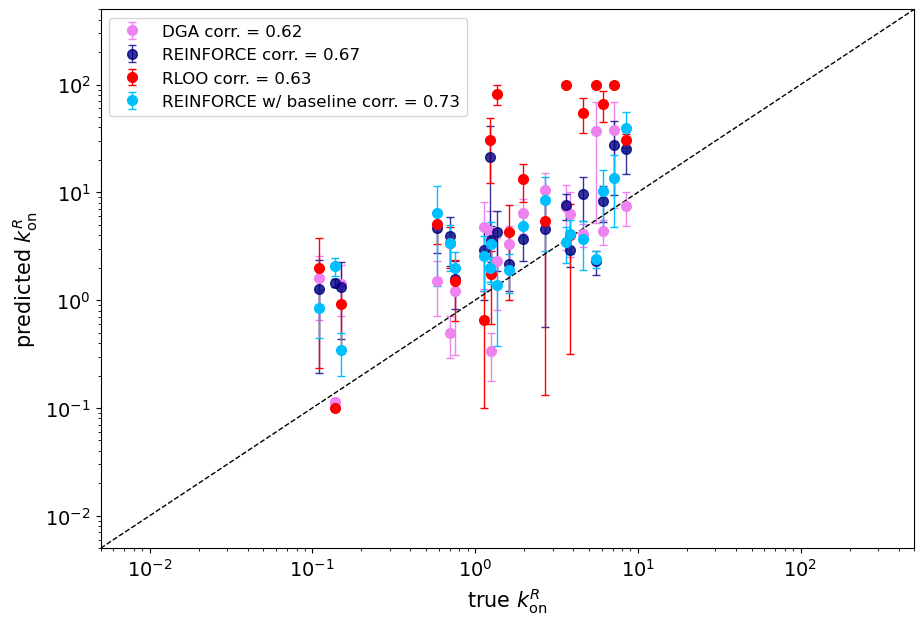

In [324]:
plt.figure(figsize=(10.5,7))
#plt.scatter(true_kon, estimated_kon, color = "navy", label = f'REINFORCE corr. = {corr_kon:.2f}')
#plt.scatter(true_kon, estimated_kon_b, color = "deepskyblue", label = f'REINFORCE w/ baseline corr. = {corr_kon_b:.2f}')
#plt.scatter(true_kon_RLOO, estimated_kon_RLOO, color = "red", label = f'RLOO corr. = {corr_kon_RLOO:.2f}')
#plt.scatter(true_kon, estimated_kon_dga, s = 60, color = "violet", label = f'DGA corr. = {corr_kon_dga:.2f}', zorder = 10)

plt.errorbar(true_kon, estimated_kon_dga, fmt = 'o', markersize = 7, yerr=kon_std_dga/np.sqrt(3), color='violet', ecolor='violet', elinewidth=1, capsize=3,
                label = f'DGA corr. = {corr_kon_dga:.2f}')
plt.errorbar(true_kon, estimated_kon, fmt = 'o', markersize = 7, alpha = 0.8, yerr=kon_std/np.sqrt(5), color='navy', ecolor='navy', elinewidth=1, capsize=3,
                label=f'REINFORCE corr. = {corr_kon:.2f}')
plt.errorbar(true_kon, estimated_kon_RLOO, fmt = 'o', markersize = 7, yerr=kon_std_RLOO/np.sqrt(5), color='red', ecolor='red', elinewidth=1, capsize=3,
                label=f'RLOO corr. = {corr_kon_RLOO:.2f}')
plt.errorbar(true_kon, estimated_kon_b, fmt = 'o', markersize = 7, yerr=kon_std_b/np.sqrt(5), color='deepskyblue', ecolor='deepskyblue', elinewidth=1, capsize=3,
                label = f'REINFORCE w/ baseline corr. = {corr_kon_b:.2f}')
plt.plot([5e-3, 5e2], [5e-3, 5e2], 'k--', lw=1)
plt.ylim(5e-3, 5e2)
plt.xlim(5e-3, 5e2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'true $k_{\mathrm{on}}^R$', fontsize = 15)
plt.ylabel(r'predicted $k_{\mathrm{on}}^R$', fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.savefig("kon_synthetic_20.png", dpi=150)
plt.show()

## Plot r

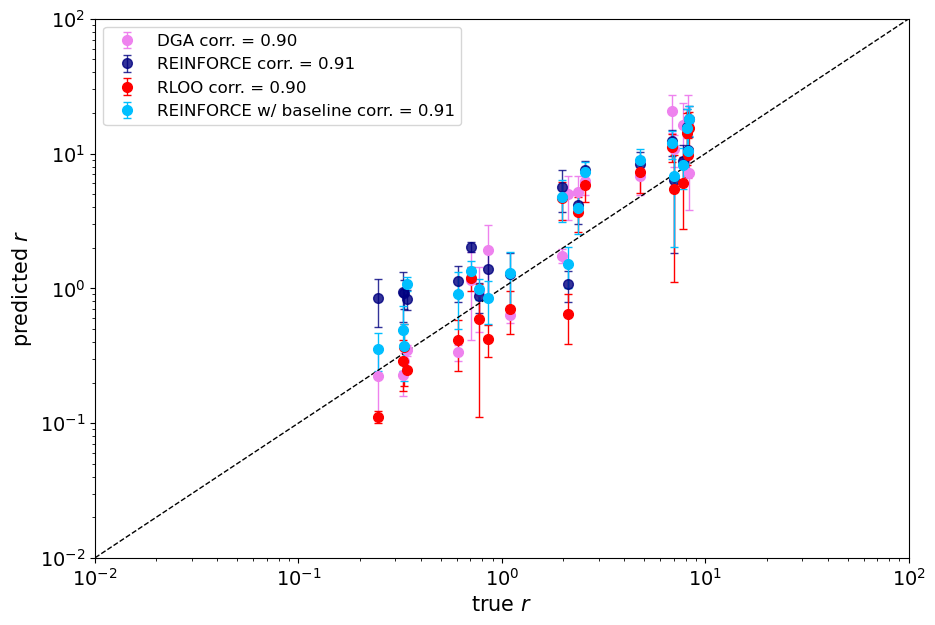

In [326]:
plt.figure(figsize=(10.5,7))

#plt.scatter(true_r, estimated_r, color = "navy", label = f'REINFORCE corr. = {corr_r:.2f}')
#plt.scatter(true_r, estimated_r_b, color = "deepskyblue", label = f'REINFORCE w/ baseline corr. = {corr_r_b:.2f}')
#plt.scatter(true_r_RLOO, estimated_r_RLOO, color = "red", label = f'RLOO corr. = {corr_r_RLOO:.2f}')

plt.errorbar(true_r, estimated_r_dga, fmt = 'o', markersize = 7, yerr=r_std_dga/np.sqrt(3), color='violet', ecolor='violet', elinewidth=1, capsize=3,
                label = f'DGA corr. = {corr_r_dga:.2f}')
plt.errorbar(true_r, estimated_r, fmt = 'o', markersize = 7, alpha = 0.8, yerr=r_std/np.sqrt(5), color='navy', ecolor='navy', elinewidth=1, capsize=3,
                label = f'REINFORCE corr. = {corr_r:.2f}')
plt.errorbar(true_r, estimated_r_RLOO, fmt = 'o', markersize = 7, yerr=r_std_RLOO/np.sqrt(5), color='red', ecolor='red', elinewidth=1, capsize=3,
                label = f'RLOO corr. = {corr_r_RLOO:.2f}')
plt.errorbar(true_r, estimated_r_b, fmt = 'o', markersize = 7, yerr=r_std_b/np.sqrt(5), color='deepskyblue', ecolor='deepskyblue', elinewidth=1, capsize=3,
                label = f'REINFORCE w/ baseline corr. = {corr_r_b:.2f}')
#plt.scatter(true_r_dga, estimated_r_dga, s = 60, color = "violet", label = f'DGA corr. = {corr_r_dga:.2f}', zorder = 10)
plt.plot([5e-3, 5e2], [5e-3, 5e2], 'k--', lw=1)
plt.ylim(1e-2, 1e2)
plt.xlim(1e-2, 1e2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'true $r$', fontsize=15)
plt.ylabel(r'predicted $r$', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.savefig("r_synthetic_20.png", dpi=150)
plt.show()


In [328]:
#True Values
exact_mean_long = true_values_long[:,3] 
exact_std_long = true_values_long[:,4] 

exact_mean = true_values[:,3] 
exact_std = true_values[:,4] 

g= true_values[:,2]

#REINFORCE
pred_mean = reinforce_min[:, 3]  
pred_std = reinforce_min[:, 4]  

mean_err = reinforce_std[:, 3]  
std_err = reinforce_std[:, 4]  


#REINFORCE with baseline
pred_mean_b = reinforce_baseline_min[:, 3]  
pred_std_b = reinforce_baseline_min[:, 4]  

mean_b_err = reinforce_baseline_std[:, 3]  
std_b_err = reinforce_baseline_std[:, 4] 

#dga
#exact_mean_dga = true_values_dga[:,3] 
#exact_std_dga = true_values_dga[:,4] 

pred_mean_dga = dga_min[:, 3]  
pred_std_dga = dga_min[:, 4]  

mean_dga_err = dga_std[:, 3]  
std_dga_err = dga_std[:, 3]

#RLOO
pred_mean_RLOO = rloo_min[:, 3]  
mean_RLOO_err = rloo_std[:, 3]  


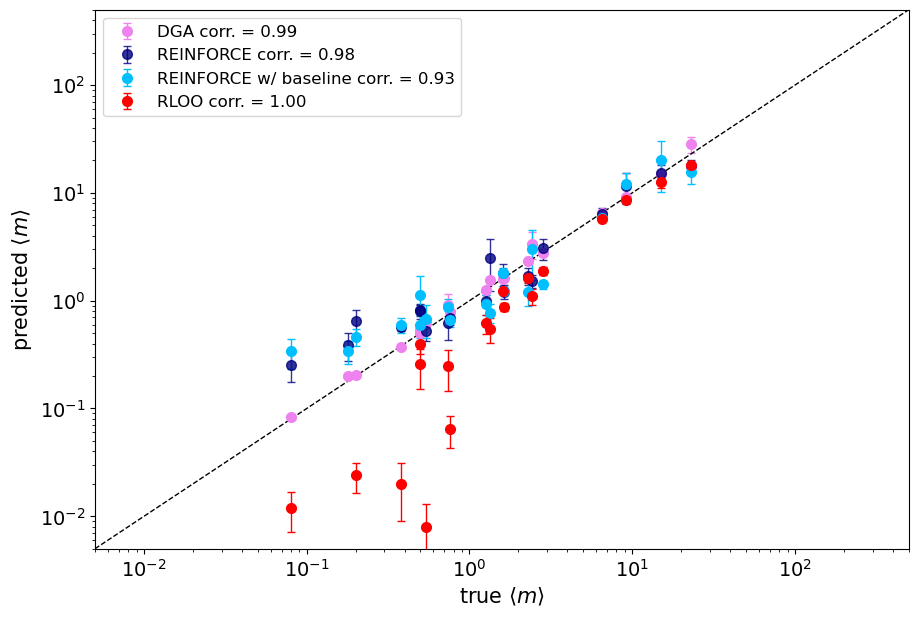

In [330]:
corr_mean_RLOO, _ = pearsonr(exact_mean, pred_mean_RLOO)
corr_mean, _ = pearsonr(exact_mean, pred_mean)
corr_mean_dga, _ = pearsonr(exact_mean, pred_mean_dga)
corr_mean_b, _ = pearsonr(exact_mean, pred_mean_b)

plt.figure(figsize=(10.5,7))
#plt.scatter(exact_mean, pred_mean, color = "navy", label = f'REINFORCE corr. = {corr_mean:.2f}')
#plt.scatter(exact_mean, pred_mean_b, color = "deepskyblue", label = f'REINFORCE w/ baseline corr. = {corr_mean_b:.2f}')
#plt.scatter(exact_mean_RLOO, pred_mean_RLOO, color = "red", label = f'RLOO corr. = {corr_mean_RLOO:.2f}')

plt.errorbar(exact_mean, pred_mean_dga, fmt = 'o', markersize = 7, yerr=mean_dga_err/np.sqrt(3), ecolor='violet', elinewidth=1, capsize=3, color = "violet", 
             label = f'DGA corr. = {corr_mean_dga:.2f}')
plt.errorbar(exact_mean, pred_mean, fmt = 'o', markersize = 7, alpha = 0.8, yerr=mean_err/np.sqrt(5), ecolor='navy', elinewidth=1, capsize=3, color = "navy", 
             label = f'REINFORCE corr. = {corr_mean:.2f}')
plt.errorbar(exact_mean, pred_mean_b, color = "deepskyblue", fmt = 'o', markersize = 7, yerr=mean_b_err/np.sqrt(5), ecolor='deepskyblue', elinewidth=1, capsize=3,
             label = f'REINFORCE w/ baseline corr. = {corr_mean_b:.2f}')
plt.errorbar(exact_mean, pred_mean_RLOO, color = "red", fmt = 'o', markersize = 7, yerr=mean_RLOO_err/np.sqrt(5), ecolor='red', elinewidth=1, capsize=3,
             label = f'RLOO corr. = {corr_mean_RLOO:.2f}')

#plt.scatter(exact_mean_dga, pred_mean_dga, color = "violet", s = 60, label = f'DGA corr. = {corr_mean_dga:.2f}', zorder = 10)
plt.plot([5e-3, 5e2], [5e-3, 5e2], 'k--', lw=1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'true $\langle m \rangle $', fontsize = 15)
plt.ylabel(r'predicted $\langle m \rangle$', fontsize = 15)
plt.ylim(5e-3, 5e2)
plt.xlim(5e-3, 5e2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.savefig("mean_synthetic_20.png", dpi = 150)
plt.show()

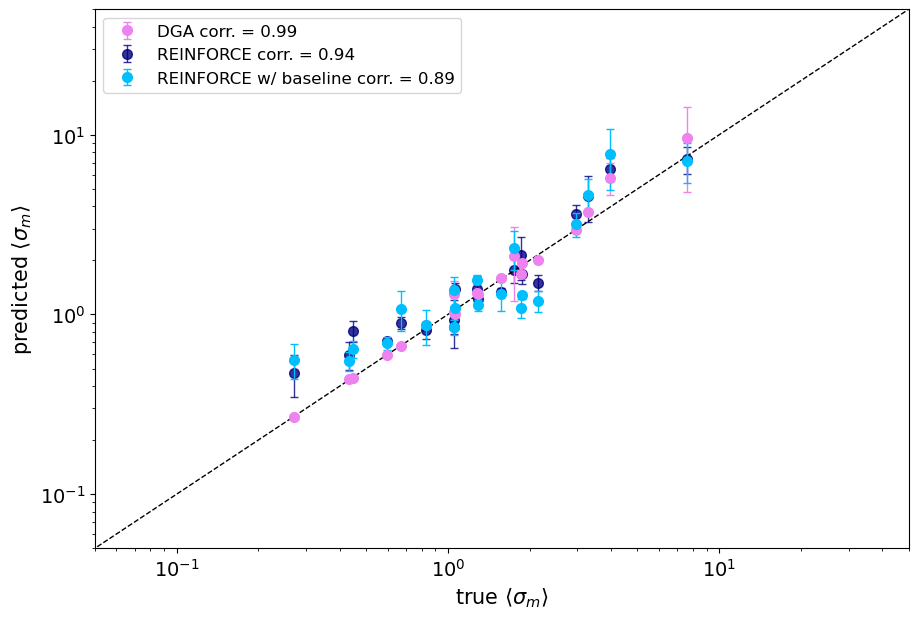

In [332]:
corr_std, _ = pearsonr(exact_std, pred_std)
corr_std_dga, _ = pearsonr(exact_std, pred_std_dga)
corr_std_b, _ = pearsonr(exact_std, pred_std_b)

plt.figure(figsize=(10.5,7))

#plt.scatter(exact_std, pred_std, color = "navy", label = f'REINFORCE corr. = {corr_std:.2f}')
#plt.scatter(exact_std, pred_std_b, color = "deepskyblue", label = f'REINFORCE w/ baseline corr. = {corr_std_b:.2f}')
#plt.scatter(exact_std, pred_std_dga, color = "violet", label = f'DGA corr. = {corr_std_dga:.2f}', zorder = 10)
plt.plot([5e-3, 5e2], [5e-3, 5e2], 'k--', lw=1)

plt.errorbar(exact_std, pred_std_dga, color = "violet", fmt = 'o', markersize = 7, yerr=std_dga_err/np.sqrt(3), ecolor='violet', elinewidth=1, capsize=3,
             label = f'DGA corr. = {corr_std_dga:.2f}')
plt.errorbar(exact_std, pred_std, color = "navy", fmt = 'o', markersize = 7, alpha = 0.8, yerr=std_err/np.sqrt(5), ecolor='navy', elinewidth=1, capsize=3,
             label = f'REINFORCE corr. = {corr_std:.2f}', zorder = 0)
plt.errorbar(exact_std, pred_std_b, color = "deepskyblue", fmt = 'o', markersize = 7, yerr=std_b_err/np.sqrt(5), ecolor='deepskyblue', elinewidth=1, capsize=3,
             label = f'REINFORCE w/ baseline corr. = {corr_std_b:.2f}')
#plt.scatter(exact_std_dga, pred_std_dga, color = "violet", s = 60, label = f'DGA corr. = {corr_std_dga:.2f}', zorder=10)

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'true $\langle \sigma_m \rangle $', fontsize = 15)
plt.ylabel(r'predicted $\langle \sigma_m \rangle $', fontsize = 15)
plt.ylim(5e-2, 5e1)
plt.xlim(5e-2, 5e1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.savefig("std_synthetic_20.png", dpi = 150)
plt.show()

# Plots for 100 values

In [199]:
corr_kon, _ = pearsonr(true_kon_long, estimated_kon)
corr_r, _ = pearsonr(true_r_long, estimated_r)

corr_kon_RLOO, _ = pearsonr(true_kon_long, estimated_kon_RLOO)
corr_r_RLOO, _ = pearsonr(true_r_long, estimated_r_RLOO)

corr_kon_dga, _ = pearsonr(true_kon_dga, estimated_kon_dga)
corr_r_dga, _ = pearsonr(true_r_dga, estimated_r_dga)

corr_kon_b, _ = pearsonr(true_kon_long, estimated_kon_b)
corr_r_b, _ = pearsonr(true_r_long, estimated_r_b)

## Plot kon

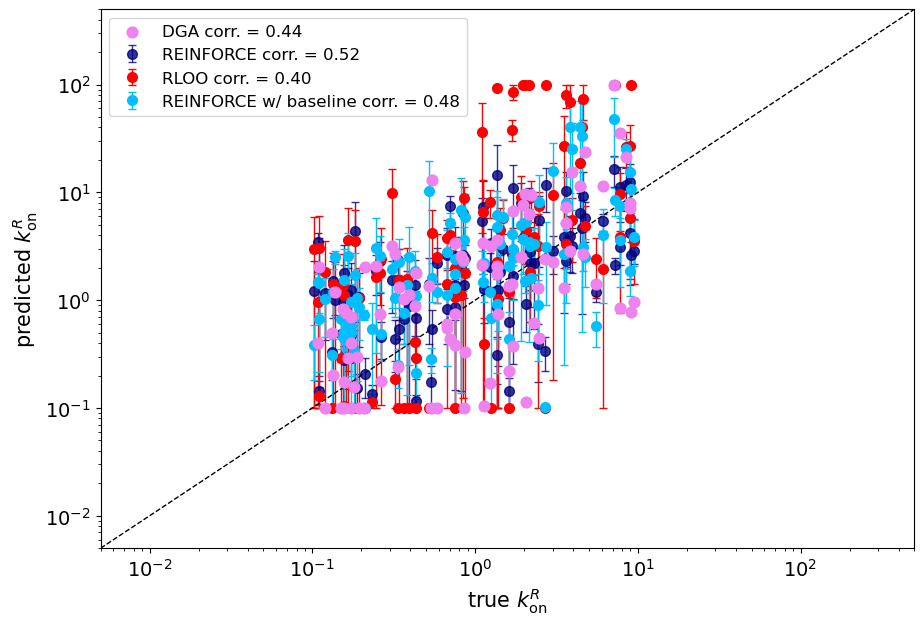

In [298]:
plt.figure(figsize=(10.5,7))

plt.scatter(true_kon_dga, estimated_kon_dga, s = 60, color = "violet", label = f'DGA corr. = {corr_kon_dga:.2f}', zorder = 10)

plt.errorbar(true_kon_long, estimated_kon, fmt = 'o', markersize = 7, alpha = 0.8, yerr=kon_std/np.sqrt(3), color='navy', ecolor='navy', elinewidth=1, capsize=3,
                label=f'REINFORCE corr. = {corr_kon:.2f}')
plt.errorbar(true_kon_long, estimated_kon_RLOO, fmt = 'o', markersize = 7, yerr=kon_std_RLOO/np.sqrt(3), color='red', ecolor='red', elinewidth=1, capsize=3,
                label=f'RLOO corr. = {corr_kon_RLOO:.2f}')
plt.errorbar(true_kon_long, estimated_kon_b, fmt = 'o', markersize = 7, yerr=kon_std_b/np.sqrt(3), color='deepskyblue', ecolor='deepskyblue', elinewidth=1, capsize=3,
                label = f'REINFORCE w/ baseline corr. = {corr_kon_b:.2f}')
plt.plot([5e-3, 5e2], [5e-3, 5e2], 'k--', lw=1)
plt.ylim(5e-3, 5e2)
plt.xlim(5e-3, 5e2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'true $k_{\mathrm{on}}^R$', fontsize = 15)
plt.ylabel(r'predicted $k_{\mathrm{on}}^R$', fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.savefig("kon_synthetic_100.png", dpi=150)
plt.show()

## Plot r

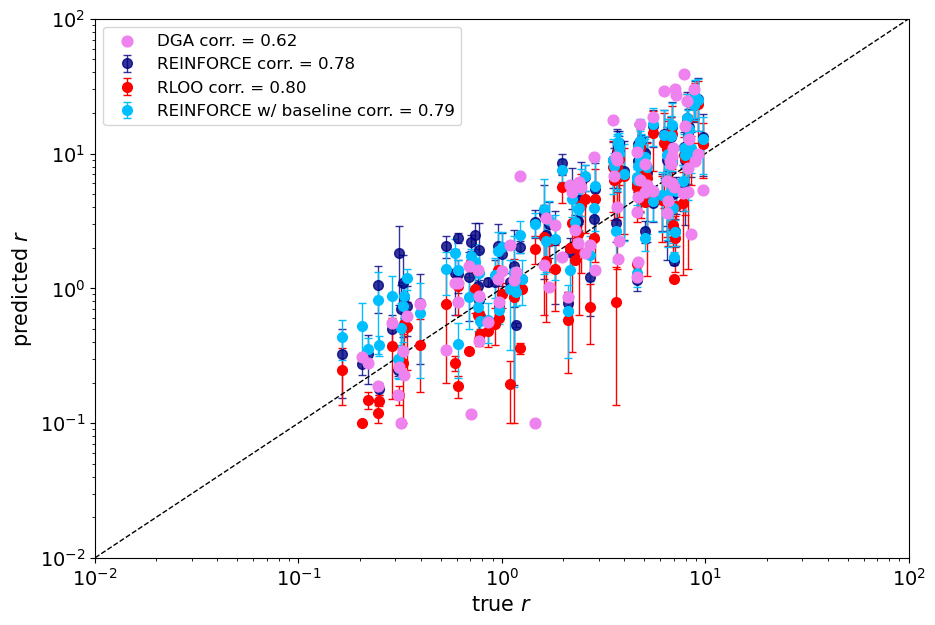

In [300]:
plt.figure(figsize=(10.5,7))
#plt.scatter(true_r, estimated_r, color = "navy", label = f'REINFORCE corr. = {corr_r:.2f}')
#plt.scatter(true_r, estimated_r_b, color = "deepskyblue", label = f'REINFORCE w/ baseline corr. = {corr_r_b:.2f}')
#plt.scatter(true_r_RLOO, estimated_r_RLOO, color = "red", label = f'RLOO corr. = {corr_r_RLOO:.2f}')

plt.errorbar(true_r_long, estimated_r, fmt = 'o', markersize = 7, alpha = 0.8, yerr=r_std/np.sqrt(3), color='navy', ecolor='navy', elinewidth=1, capsize=3,
                label = f'REINFORCE corr. = {corr_r:.2f}')
plt.errorbar(true_r_long, estimated_r_RLOO, fmt = 'o', markersize = 7, yerr=r_std_RLOO/np.sqrt(3), color='red', ecolor='red', elinewidth=1, capsize=3,
                label = f'RLOO corr. = {corr_r_RLOO:.2f}')
plt.errorbar(true_r_long, estimated_r_b, fmt = 'o', markersize = 7, yerr=r_std_b/np.sqrt(3), color='deepskyblue', ecolor='deepskyblue', elinewidth=1, capsize=3,
                label = f'REINFORCE w/ baseline corr. = {corr_r_b:.2f}')
plt.scatter(true_r_dga, estimated_r_dga, s = 60, color = "violet", label = f'DGA corr. = {corr_r_dga:.2f}', zorder = 10)
plt.plot([5e-3, 5e2], [5e-3, 5e2], 'k--', lw=1)
plt.ylim(1e-2, 1e2)
plt.xlim(1e-2, 1e2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'true $r$', fontsize=15)
plt.ylabel(r'predicted $r$', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.savefig("r_synthetic_100.png", dpi=150)
plt.show()

## extract mean and standard deviation values

In [264]:
#True Values
exact_mean_long = true_values_long[:,3] 
exact_std_long = true_values_long[:,4] 

#REINFORCE
pred_mean = reinforce_min[:, 3]  
pred_std = reinforce_min[:, 4]  

mean_err = reinforce_std[:, 3]  
std_err = reinforce_std[:, 4]  


#REINFORCE with baseline
pred_mean_b = reinforce_baseline_min[:, 3]  
pred_std_b = reinforce_baseline_min[:, 4]  

mean_b_err = reinforce_baseline_std[:, 3]  
std_b_err = reinforce_baseline_std[:, 4] 

#dga
exact_mean_dga = true_values_dga[:,3] 
exact_std_dga = true_values_dga[:,4] 

pred_mean_dga = dga_min[:, 3]  
pred_std_dga = dga_min[:, 4]  

#RLOO
pred_mean_RLOO = rloo_min[:, 3]  
mean_RLOO_err = rloo_std[:, 3]  

## Plot mean

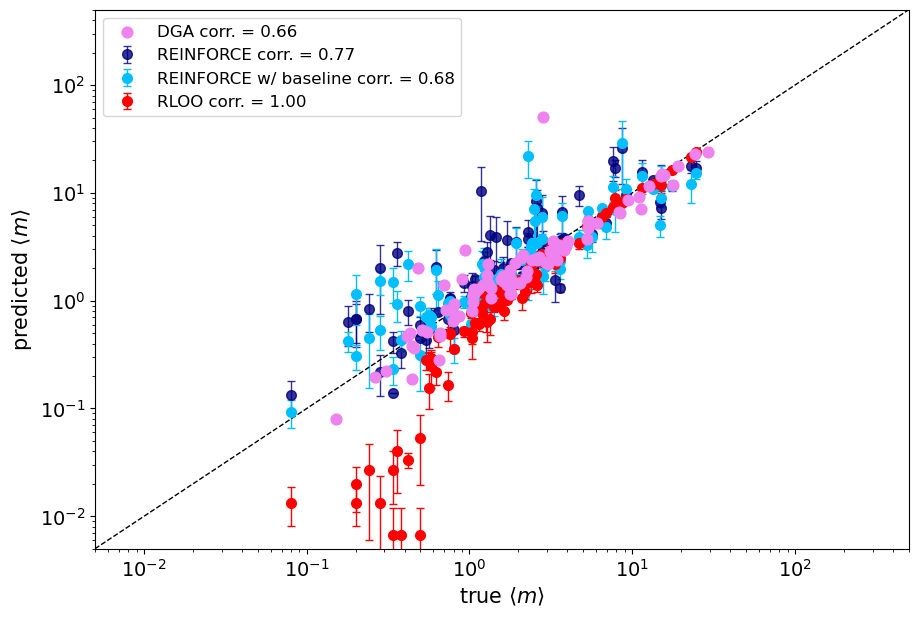

In [302]:
corr_mean_RLOO, _ = pearsonr(exact_mean_long, pred_mean_RLOO)
corr_mean, _ = pearsonr(exact_mean_long, pred_mean)
corr_mean_dga, _ = pearsonr(exact_mean_dga, pred_mean_dga)
corr_mean_b, _ = pearsonr(exact_mean_long, pred_mean_b)

plt.figure(figsize=(10.5,7))

plt.errorbar(exact_mean_long, pred_mean, fmt = 'o', markersize = 7, alpha = 0.8, yerr=mean_err/np.sqrt(5), ecolor='navy', elinewidth=1, capsize=3, color = "navy", 
             label = f'REINFORCE corr. = {corr_mean:.2f}')
plt.errorbar(exact_mean_long, pred_mean_b, color = "deepskyblue", fmt = 'o', markersize = 7, yerr=mean_b_err/np.sqrt(5), ecolor='deepskyblue', elinewidth=1, capsize=3,
             label = f'REINFORCE w/ baseline corr. = {corr_mean_b:.2f}')
plt.errorbar(exact_mean_long, pred_mean_RLOO, color = "red", fmt = 'o', markersize = 7, yerr=mean_RLOO_err/np.sqrt(5), ecolor='red', elinewidth=1, capsize=3,
             label = f'RLOO corr. = {corr_mean_RLOO:.2f}')

plt.scatter(exact_mean_dga, pred_mean_dga, color = "violet", s = 60, label = f'DGA corr. = {corr_mean_dga:.2f}', zorder = 10)
plt.plot([5e-3, 5e2], [5e-3, 5e2], 'k--', lw=1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'true $\langle m \rangle $', fontsize = 15)
plt.ylabel(r'predicted $\langle m \rangle$', fontsize = 15)
plt.ylim(5e-3, 5e2)
plt.xlim(5e-3, 5e2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.savefig("mean_synthetic_100.png", dpi = 150)
plt.show()

## Plot standard deviation

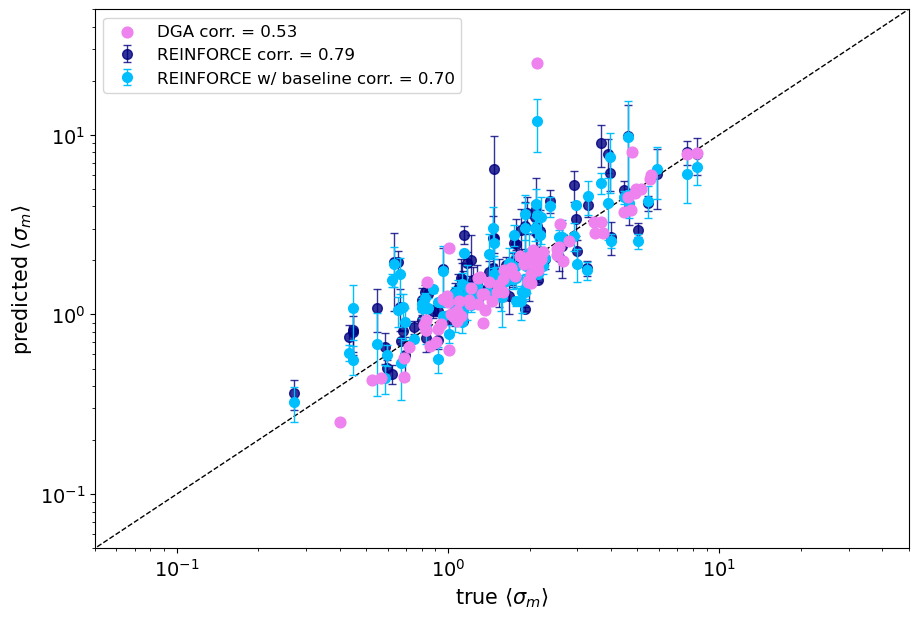

In [304]:
corr_std, _ = pearsonr(exact_std_long, pred_std)
corr_std_dga, _ = pearsonr(exact_std_dga, pred_std_dga)
corr_std_b, _ = pearsonr(exact_std_long, pred_std_b)

plt.figure(figsize=(10.5,7))

plt.plot([5e-3, 5e2], [5e-3, 5e2], 'k--', lw=1)

plt.errorbar(exact_std_long, pred_std, color = "navy", fmt = 'o', markersize = 7, alpha = 0.8, yerr=std_err/np.sqrt(5), ecolor='navy', elinewidth=1, capsize=3,
             label = f'REINFORCE corr. = {corr_std:.2f}', zorder = 0)
plt.errorbar(exact_std_long, pred_std_b, color = "deepskyblue", fmt = 'o', markersize = 7, yerr=std_b_err/np.sqrt(5), ecolor='deepskyblue', elinewidth=1, capsize=3,
             label = f'REINFORCE w/ baseline corr. = {corr_std_b:.2f}')
plt.scatter(exact_std_dga, pred_std_dga, color = "violet", s = 60, label = f'DGA corr. = {corr_std_dga:.2f}', zorder=10)

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'true $\langle \sigma_m \rangle $', fontsize = 15)
plt.ylabel(r'predicted $\langle \sigma_m \rangle $', fontsize = 15)
plt.ylim(5e-2, 5e1)
plt.xlim(5e-2, 5e1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.savefig("std_synthetic_100.png", dpi = 150)
plt.show()